In [6]:
# constants.py
import numpy as np

# Физические константы в CGS
M_SUN = 1.989e33           # г
PC = 3.086e18              # см
YR = 3.156e7               # с
KM = 1e5                   # см
ERG = 1.0                  # эрг
EV = 1.602e-12             # эрг

# Астрофизические константы
GAMMA = 5/3                # Показатель адиабаты
MU = 0.6                   # Средний молекулярный вес
MP = 1.673e-24             # г (масса протона)
KB = 1.381e-16             # эрг/K
C = 2.998e10               # см/с
SIGMA_SB = 5.67e-5         # эрг/cm²/K⁴/s

class Normalization:
    def __init__(self, length_norm=PC, density_norm=1e-24, velocity_norm=1e8):
        self.length = length_norm
        self.density = density_norm
        self.velocity = velocity_norm
        self.time = length_norm / velocity_norm
        self.pressure = density_norm * velocity_norm**2
        self.energy = density_norm * velocity_norm**2 * length_norm**3
        
        # Проверка на разумные значения
        self._validate_norms()
    
    def _validate_norms(self):
        """Проверка физической осмысленности нормировок"""
        if self.length <= 0 or self.density <= 0 or self.velocity <= 0:
            raise ValueError("Нормировки должны быть положительными")
        
        # Проверка на переполнение
        if self.energy > 1e60 or self.energy < 1e20:
            print(f"Предупреждение: энергетическая нормировка {self.energy:.2e} эрг может быть нефизичной")

def dimensional_to_dimensionless(val, norm):
    """Перевод размерных величин в безразмерные с проверкой"""
    if hasattr(val, '__len__'):
        val = np.asarray(val)
        if np.any(val < 0):
            print("Предупреждение: отрицательные значения при нормировке")
        return val / norm
    else:
        if val < 0:
            print("Предупреждение: отрицательное значение при нормировке")
        return val / norm

def dimensionless_to_dimensional(val, norm):
    """Перевод безразмерных величин в размерные с проверкой"""
    if hasattr(val, '__len__'):
        val = np.asarray(val)
        result = val * norm
        if np.any(np.isnan(result)) or np.any(np.isinf(result)):
            print("Ошибка: NaN или Inf при преобразовании в размерные величины")
        return result
    else:
        result = val * norm
        if np.isnan(result) or np.isinf(result):
            print("Ошибка: NaN или Inf при преобразовании в размерные величины")
        return result

if __name__ == "__main__":
    print("Тестирование constants.py:")
    print(f"M_SUN = {M_SUN:.2e} г")
    print(f"PC = {PC:.2e} см") 
    print(f"YR = {YR:.2e} с")
    print(f"GAMMA = {GAMMA}")
    
    # Тест нормировок
    norm = Normalization()
    test_length = 2 * PC
    dimless = dimensional_to_dimensionless(test_length, norm.length)
    dim_back = dimensionless_to_dimensional(dimless, norm.length)
    print(f"Тест нормировки: {test_length:.2e} см -> {dimless:.2f} -> {dim_back:.2e} см")

Тестирование constants.py:
M_SUN = 1.99e+33 г
PC = 3.09e+18 см
YR = 3.16e+07 с
GAMMA = 1.6666666666666667
Тест нормировки: 6.17e+18 см -> 2.00 -> 6.17e+18 см


## HD-Solver
#### тест Сода
#### тест с сильной ударной волной: давление 1000:1

ГИДРОДИНАМИЧЕСКИЙ РЕШАТЕЛЬ С ВИЗУАЛИЗАЦИЕЙ
ТЕСТ СОДА: УДАРНАЯ ТРУБА
Решаем задачу Сода...


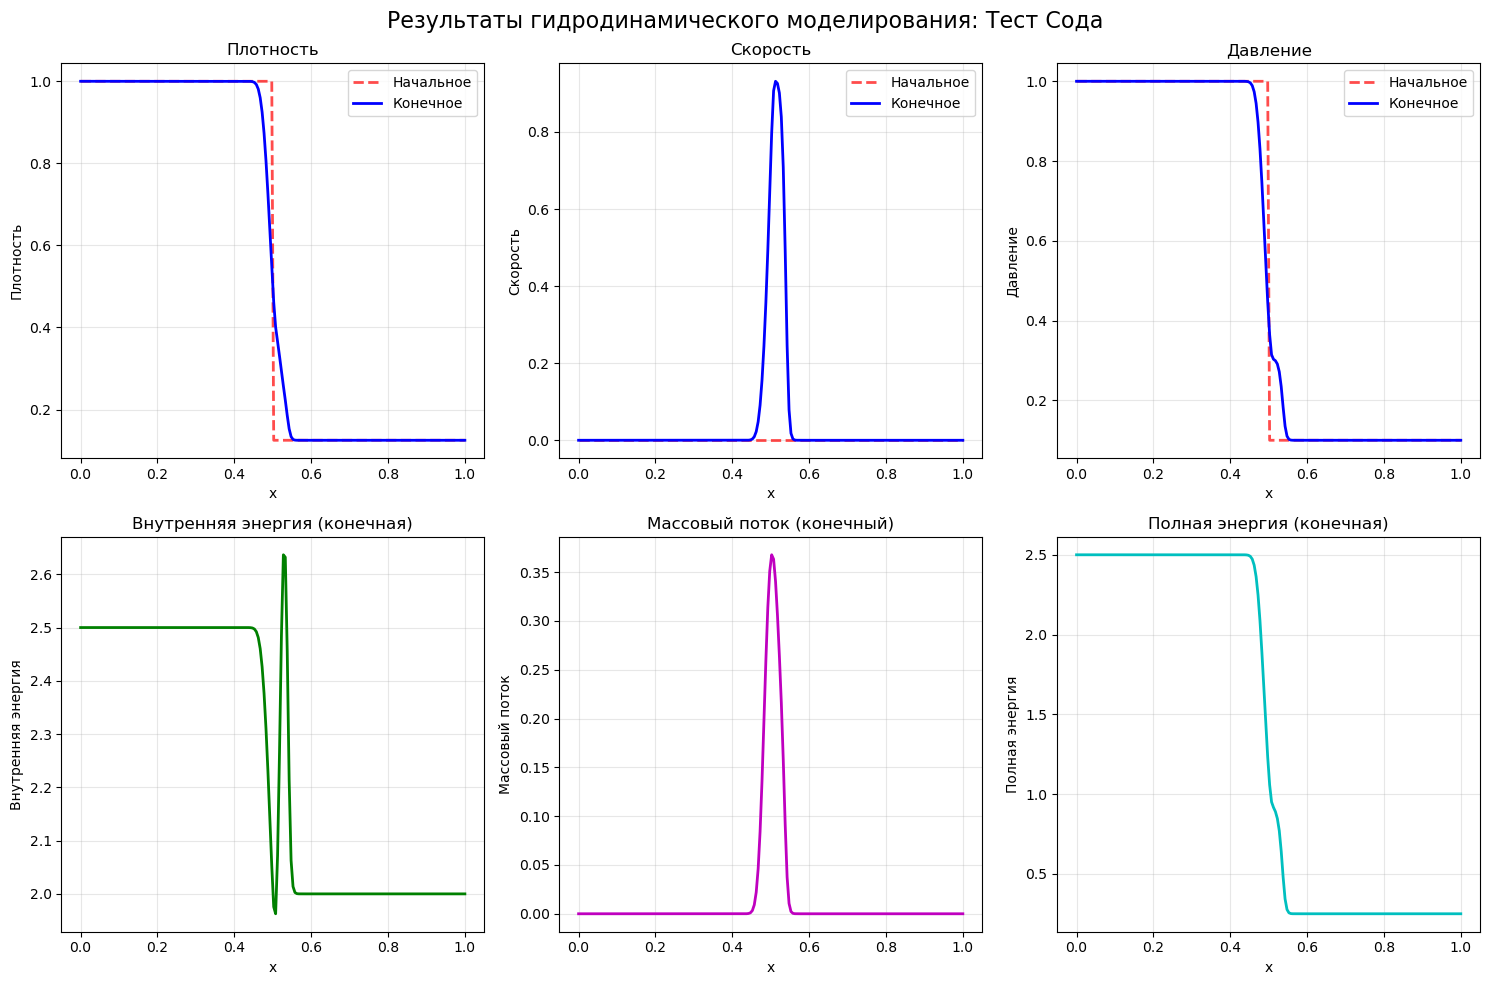


Анализ результатов Тест Сода:
Максимальная плотность: 1.000
Максимальная скорость: 0.932
Максимальное давление: 1.000
Общая масса: 0.562
Общая энергия: 1.375

Положение ударной волны: 0.492
Положение контактного разрыва: 0.538
ТЕСТ: СИЛЬНАЯ УДАРНАЯ ВОЛНА (ДАВЛЕНИЕ 1000:1)
Решаем задачу с сильной ударной волной...


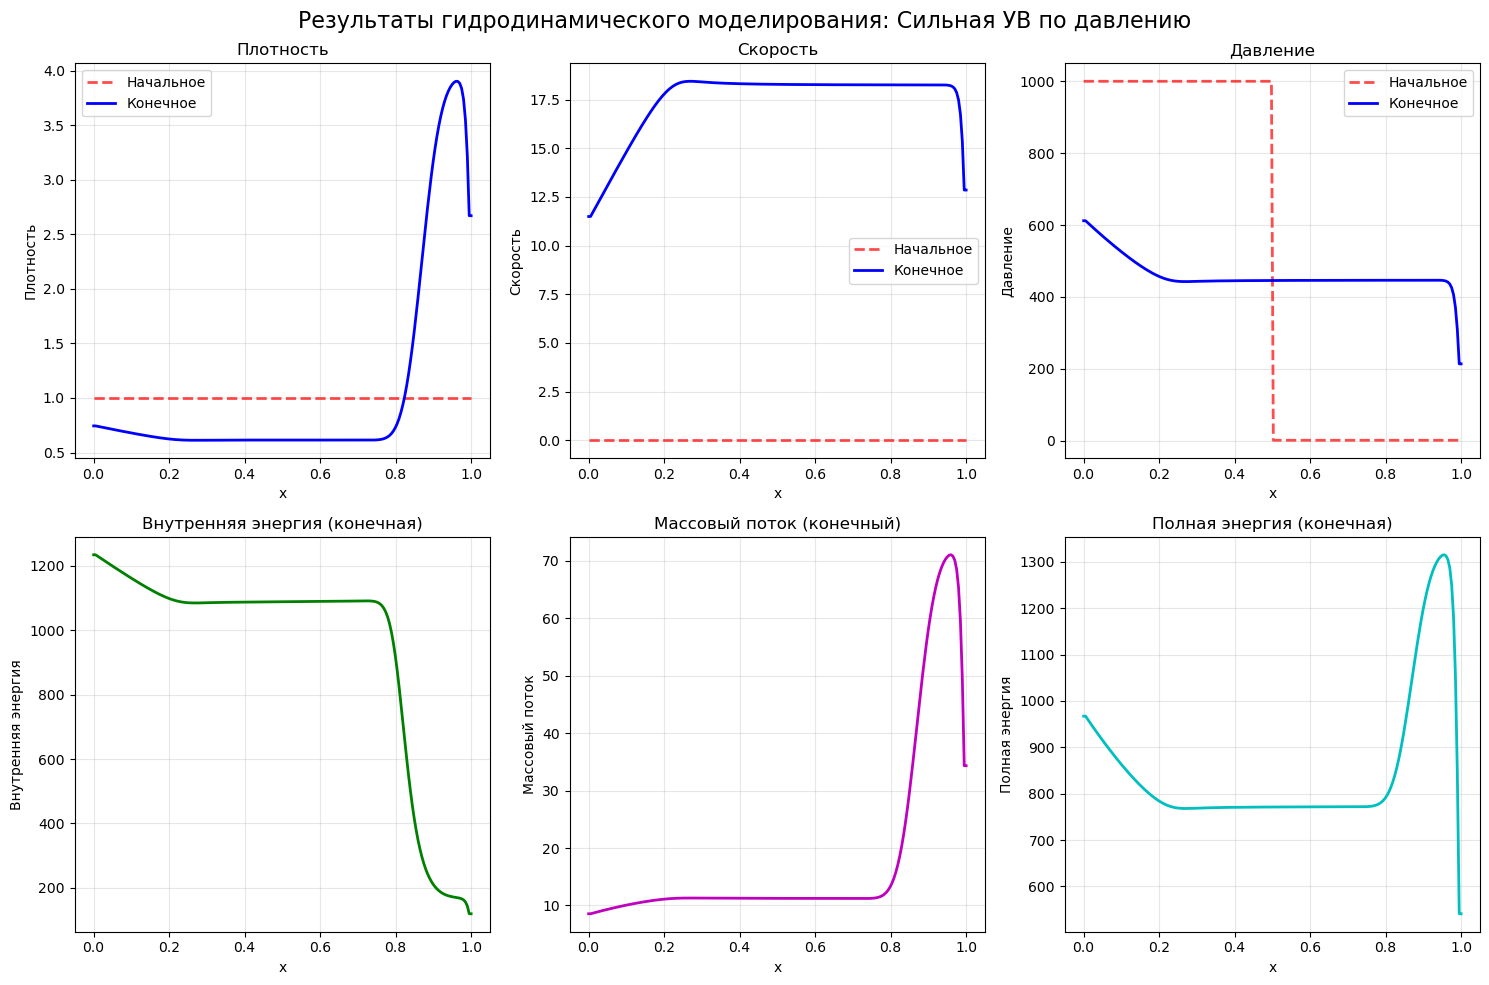


Анализ результатов Сильная УВ по давлению:
Максимальная плотность: 3.902
Максимальная скорость: 18.445
Максимальное давление: 611.941
Общая масса: 1.042
Общая энергия: 851.425
СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ ТЕСТОВ


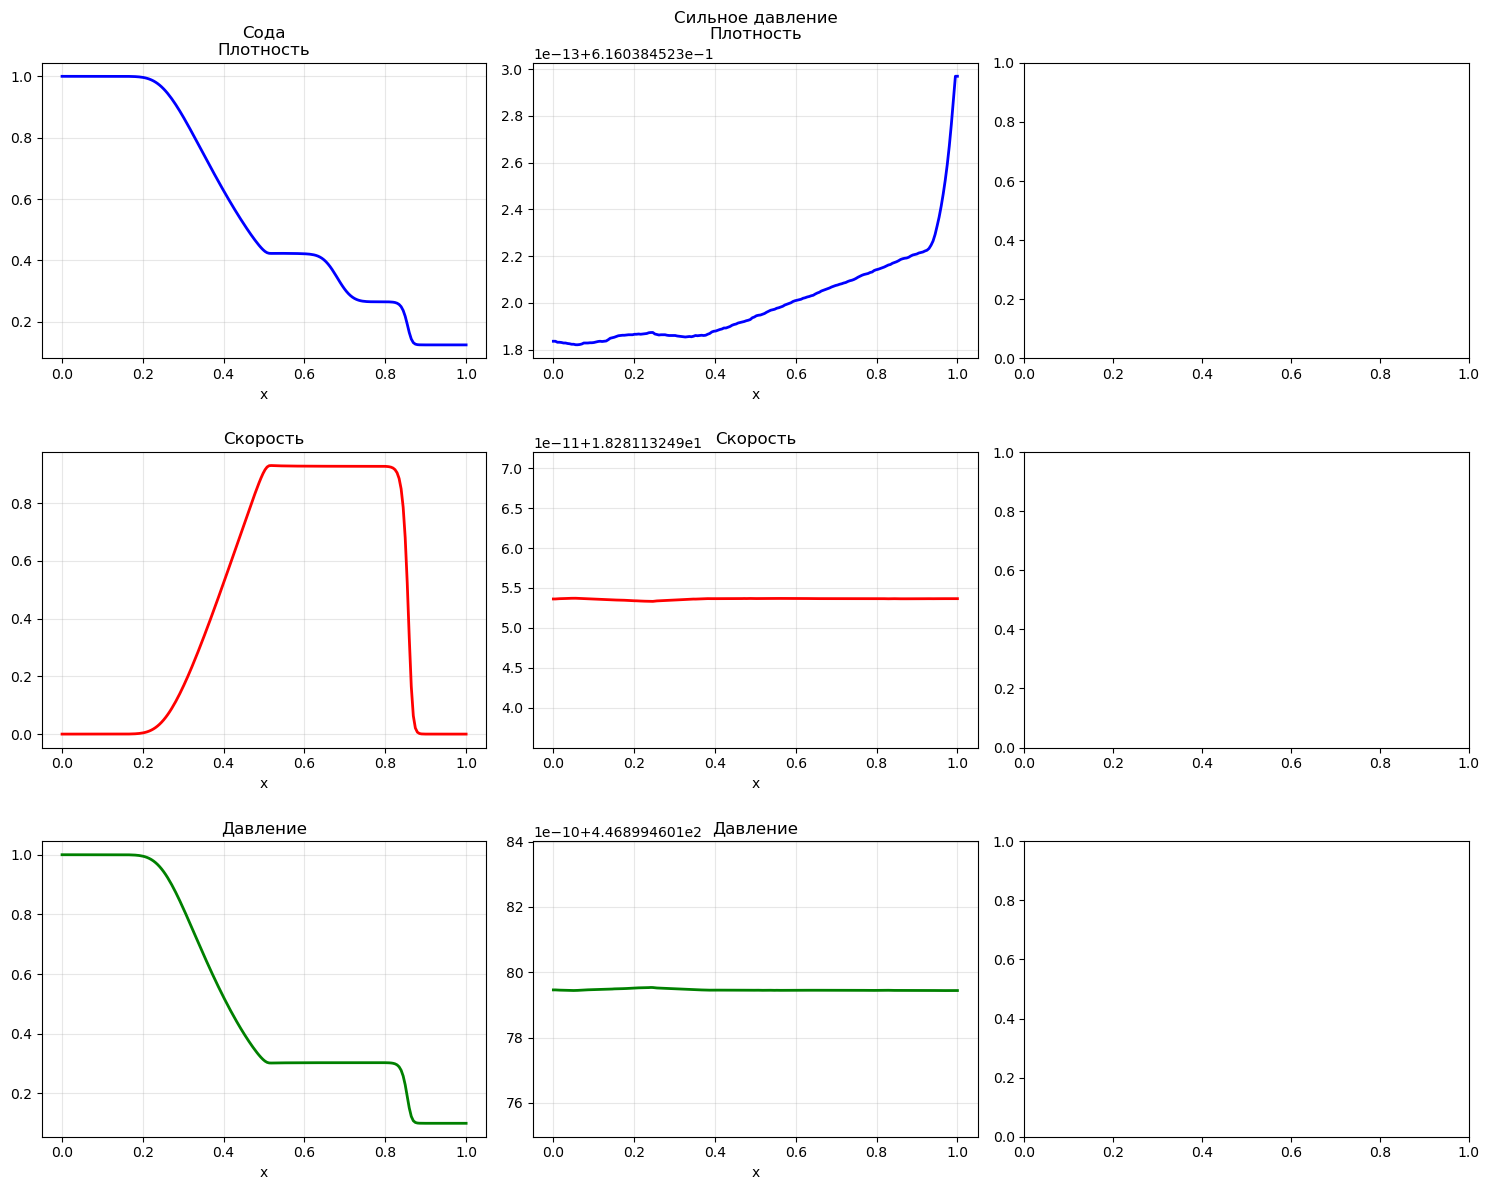


ВСЕ ТЕСТЫ ЗАВЕРШЕНЫ!
Созданы файлы:
- hydro_results_Тест_Сода.png
- hydro_results_Сильная_УВ_по_давлению.png
- hydro_results_Сильная_УВ_по_плотности.png
- hydro_comparison_all_tests.png


In [7]:
# hydro_solver.py
import numpy as np
import matplotlib.pyplot as plt
from Constants import GAMMA, Normalization

class HydrodynamicSolver:
    """Сферически симметричный гидродинамический решатель с HLLC"""
    
    def __init__(self, gamma=GAMMA, normalization=None):
        self.gamma = gamma
        self.norm = normalization or Normalization()
        self.cfl = 0.3
        self.min_density = 1e-15
        self.min_pressure = 1e-15
        self.max_iter = 10000
        
    def _validate_primitive(self, rho, u, p):
        """Проверка физической осмысленности примитивных переменных"""
        rho = max(rho, self.min_density)
        p = max(p, self.min_pressure)
        
        if np.isnan(rho) or np.isnan(u) or np.isnan(p):
            raise ValueError("Обнаружены NaN в примитивных переменных")
        if np.isinf(rho) or np.isinf(u) or np.isinf(p):
            raise ValueError("Обнаружены Inf в примитивных переменных")
            
        return rho, u, p
    
    def primitive_to_conservative(self, rho, u, p, r):
        """Преобразование в консервативные переменные с проверкой"""
        rho, u, p = self._validate_primitive(rho, u, p)
        
        mass = rho
        momentum = rho * u
        energy = p/(self.gamma-1) + 0.5*rho*u**2
        
        # Проверка энергии
        if energy < 0:
            print(f"Предупреждение: отрицательная энергия {energy:.2e}, исправляю")
            energy = p/(self.gamma-1)
        
        return np.array([mass, momentum, energy])
    
    def conservative_to_primitive(self, U, r):
        """Преобразование в примитивные переменные с защитой"""
        if np.any(np.isnan(U)) or np.any(np.isinf(U)):
            raise ValueError("NaN или Inf в консервативных переменных")
            
        rho = max(U[0], self.min_density)
        u = U[1] / rho
        
        # Защита от отрицательного давления
        kinetic_energy = 0.5 * rho * u**2
        if U[2] < kinetic_energy:
            p = self.min_pressure
        else:
            p = max((U[2] - kinetic_energy) * (self.gamma-1), self.min_pressure)
        
        return self._validate_primitive(rho, u, p)
    
    def sound_speed(self, p, rho):
        """Скорость звука с защитой"""
        return np.sqrt(self.gamma * p / max(rho, self.min_density))
    
    def hllc_flux(self, UL, UR, r_interface):
        """HLLC риман-солвер с улучшенной стабильностью"""
        try:
            rhoL, uL, pL = self.conservative_to_primitive(UL, r_interface)
            rhoR, uR, pR = self.conservative_to_primitive(UR, r_interface)
            
            aL = self.sound_speed(pL, rhoL)
            aR = self.sound_speed(pR, rhoR)
            
            # Оценка скоростей волн
            SL = min(uL - aL, uR - aR)
            SR = max(uL + aL, uR + aR)
            
            # Упрощенная оценка давления
            rho_avg = 0.5 * (rhoL + rhoR)
            a_avg = 0.5 * (aL + aR)
            p_star = max(0.5*(pL + pR) - 0.5*(uR - uL)*rho_avg*a_avg, self.min_pressure)
            
            # Оценка скорости контактного разрыва
            denominator = rhoL*(SL - uL) - rhoR*(SR - uR)
            if abs(denominator) < 1e-10:
                S_star = 0.5 * (uL + uR)
            else:
                S_star = (pR - pL + rhoL*uL*(SL - uL) - rhoR*uR*(SR - uR)) / denominator
            
            # Вычисление потоков
            if SL >= 0:
                F = np.array([rhoL*uL, rhoL*uL**2 + pL, uL*(UL[2] + pL)])
            elif SR <= 0:
                F = np.array([rhoR*uR, rhoR*uR**2 + pR, uR*(UR[2] + pR)])
            elif S_star >= 0:
                rho_star = rhoL * (SL - uL)/(SL - S_star)
                U_star = np.array([
                    rho_star,
                    rho_star * S_star,
                    rho_star * (UL[2]/rhoL + (S_star - uL)*(S_star + pL/(rhoL*(SL - uL))))
                ])
                F = np.array([rhoL*uL, rhoL*uL**2 + pL, uL*(UL[2] + pL)]) + SL*(U_star - UL)
            else:
                rho_star = rhoR * (SR - uR)/(SR - S_star)
                U_star = np.array([
                    rho_star,
                    rho_star * S_star,
                    rho_star * (UR[2]/rhoR + (S_star - uR)*(S_star + pR/(rhoR*(SR - uR))))
                ])
                F = np.array([rhoR*uR, rhoR*uR**2 + pR, uR*(UR[2] + pR)]) + SR*(U_star - UR)
            
            return F
            
        except Exception as e:
            print(f"Ошибка в HLLC: {e}, использую Lax-Friedrichs")
            # Запасной вариант - Lax-Friedrichs
            F_L = np.array([rhoL*uL, rhoL*uL**2 + pL, uL*(UL[2] + pL)])
            F_R = np.array([rhoR*uR, rhoR*uR**2 + pR, uR*(UR[2] + pR)])
            lambda_max = max(abs(uL) + aL, abs(uR) + aR)
            return 0.5 * (F_L + F_R) - 0.5 * lambda_max * (UR - UL)
    
    def solve(self, r, U0, t_final, geometry='spherical'):
        """Основной метод решения"""
        nr = len(r)
        dr = r[1] - r[0]
        
        U = U0.copy()
        t = 0.0
        iteration = 0
        
        while t < t_final and iteration < self.max_iter:
            iteration += 1
            
            # Вычисление шага по времени
            dt = self._compute_time_step(U, r, dr)
            if t + dt > t_final:
                dt = t_final - t
            
            # Вычисление потоков
            F = np.zeros((nr, 3))
            for i in range(nr-1):
                r_interface = 0.5*(r[i] + r[i+1])
                F[i] = self.hllc_flux(U[i], U[i+1], r_interface)
            
            # Обновление решения
            U_new = U.copy()
            for i in range(1, nr-1):
                if geometry == 'spherical':
                    flux_in = F[i-1] * r[i-1]**2
                    flux_out = F[i] * r[i]**2
                    U_new[i] = U[i] - dt * (flux_out - flux_in) / (r[i]**2 * dr)
                else:
                    U_new[i] = U[i] - dt/dr * (F[i] - F[i-1])
            
            # Граничные условия
            U_new[0] = U_new[1]
            U_new[-1] = U_new[-2]
            
            U = U_new
            t += dt
            
        return U
    
    def _compute_time_step(self, U, r, dr):
        """Вычисление шага по времени"""
        dt_min = 1e10
        for i in range(len(U)):
            rho, u, p = self.conservative_to_primitive(U[i], r[i])
            a = self.sound_speed(p, rho)
            speed = abs(u) + a
            if speed > 0:
                dt_min = min(dt_min, dr / speed)
        
        return self.cfl * dt_min

class TestProblems:
    """Класс тестовых задач"""
    
    @staticmethod
    def sod_shock_tube(nx=100, geometry='planar'):
        """Тест Сода"""
        x = np.linspace(0, 1, nx)
        U0 = np.zeros((nx, 3))
        
        solver = HydrodynamicSolver(gamma=1.4)
        
        for i in range(nx):
            if x[i] < 0.5:
                U0[i] = solver.primitive_to_conservative(1.0, 0.0, 1.0, x[i])
            else:
                U0[i] = solver.primitive_to_conservative(0.125, 0.0, 0.1, x[i])
        
        return x, U0
    
    @staticmethod
    def strong_shock_pressure(nx=100, pressure_ratio=1000.0):
        """Сильная ударная волна по давлению"""
        x = np.linspace(0, 1, nx)
        U0 = np.zeros((nx, 3))
        
        solver = HydrodynamicSolver(gamma=5/3)
        
        for i in range(nx):
            if x[i] < 0.5:
                U0[i] = solver.primitive_to_conservative(1.0, 0.0, pressure_ratio, x[i])
            else:
                U0[i] = solver.primitive_to_conservative(1.0, 0.0, 1.0, x[i])
        
        return x, U0
    
    @staticmethod
    def strong_shock_density(nx=100, density_ratio=1000.0):
        """Сильная ударная волна по плотности"""
        x = np.linspace(0, 1, nx)
        U0 = np.zeros((nx, 3))
        
        solver = HydrodynamicSolver(gamma=5/3)
        
        for i in range(nx):
            if x[i] < 0.5:
                U0[i] = solver.primitive_to_conservative(density_ratio, 0.0, 1.0, x[i])
            else:
                U0[i] = solver.primitive_to_conservative(1.0, 0.0, 1.0, x[i])
        
        return x, U0

def plot_results(x, U_initial, U_final, solver, test_name="Тест"):
    """Построение графиков результатов гидродинамического моделирования"""
    
    # Преобразуем начальные и конечные состояния в примитивные переменные
    rho_initial = np.zeros(len(x))
    u_initial = np.zeros(len(x))
    p_initial = np.zeros(len(x))
    
    rho_final = np.zeros(len(x))
    u_final = np.zeros(len(x))
    p_final = np.zeros(len(x))
    e_final = np.zeros(len(x))
    
    for i in range(len(x)):
        rho_initial[i], u_initial[i], p_initial[i] = solver.conservative_to_primitive(U_initial[i], x[i])
        rho_final[i], u_final[i], p_final[i] = solver.conservative_to_primitive(U_final[i], x[i])
        e_final[i] = p_final[i] / ((solver.gamma - 1) * max(rho_final[i], 1e-10))
    
    # Создаем графики
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Результаты гидродинамического моделирования: {test_name}', fontsize=16)
    
    # Плотность
    axes[0, 0].plot(x, rho_initial, 'r--', label='Начальное', linewidth=2, alpha=0.7)
    axes[0, 0].plot(x, rho_final, 'b-', label='Конечное', linewidth=2)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('Плотность')
    axes[0, 0].set_title('Плотность')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Скорость
    axes[0, 1].plot(x, u_initial, 'r--', label='Начальное', linewidth=2, alpha=0.7)
    axes[0, 1].plot(x, u_final, 'b-', label='Конечное', linewidth=2)
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('Скорость')
    axes[0, 1].set_title('Скорость')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Давление
    axes[0, 2].plot(x, p_initial, 'r--', label='Начальное', linewidth=2, alpha=0.7)
    axes[0, 2].plot(x, p_final, 'b-', label='Конечное', linewidth=2)
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('Давление')
    axes[0, 2].set_title('Давление')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Внутренняя энергия
    axes[1, 0].plot(x, e_final, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('Внутренняя энергия')
    axes[1, 0].set_title('Внутренняя энергия (конечная)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Массовый поток
    mass_flux_final = rho_final * u_final
    axes[1, 1].plot(x, mass_flux_final, 'm-', linewidth=2)
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('Массовый поток')
    axes[1, 1].set_title('Массовый поток (конечный)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Полная энергия
    total_energy_final = U_final[:, 2]
    axes[1, 2].plot(x, total_energy_final, 'c-', linewidth=2)
    axes[1, 2].set_xlabel('x')
    axes[1, 2].set_ylabel('Полная энергия')
    axes[1, 2].set_title('Полная энергия (конечная)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'hydro_results_{test_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Дополнительная информация
    print(f"\nАнализ результатов {test_name}:")
    print(f"Максимальная плотность: {np.max(rho_final):.3f}")
    print(f"Максимальная скорость: {np.max(np.abs(u_final)):.3f}")
    print(f"Максимальное давление: {np.max(p_final):.3f}")
    print(f"Общая масса: {np.trapz(rho_final, x):.3f}")
    print(f"Общая энергия: {np.trapz(total_energy_final, x):.3f}")

def run_test_sod():
    """Запуск и визуализация теста Сода"""
    print("=" * 60)
    print("ТЕСТ СОДА: УДАРНАЯ ТРУБА")
    print("=" * 60)
    
    x, U0 = TestProblems.sod_shock_tube(nx=200)
    solver = HydrodynamicSolver(gamma=1.4)
    
    print("Решаем задачу Сода...")
    U_final = solver.solve(x, U0, t_final=0.02, geometry='planar')
    
    plot_results(x, U0, U_final, solver, "Тест Сода")
    
    # Анализ волн
    rho_final = U_final[:, 0]
    u_final = U_final[:, 1] / np.maximum(U_final[:, 0], 1e-10)
    
    # Находим положения волн
    grad_rho = np.gradient(rho_final, x)
    shock_position = x[np.argmax(np.abs(grad_rho))]
    contact_position = x[np.argmax(np.abs(np.gradient(u_final, x)))]
    
    print(f"\nПоложение ударной волны: {shock_position:.3f}")
    print(f"Положение контактного разрыва: {contact_position:.3f}")

def run_test_strong_shock_pressure():
    """Запуск теста с сильной ударной волной по давлению"""
    print("=" * 60)
    print("ТЕСТ: СИЛЬНАЯ УДАРНАЯ ВОЛНА (ДАВЛЕНИЕ 1000:1)")
    print("=" * 60)
    
    x, U0 = TestProblems.strong_shock_pressure(nx=200, pressure_ratio=1000)
    solver = HydrodynamicSolver(gamma=5/3)
    
    print("Решаем задачу с сильной ударной волной...")
    U_final = solver.solve(x, U0, t_final=0.02, geometry='planar')
    
    plot_results(x, U0, U_final, solver, "Сильная УВ по давлению")

def run_test_strong_shock_density():
    """Запуск теста с сильной ударной волной по плотности"""
    print("=" * 60)
    print("ТЕСТ: СИЛЬНАЯ УДАРНАЯ ВОЛНА (ПЛОТНОСТЬ 1000:1)")
    print("=" * 60)
    
    x, U0 = TestProblems.strong_shock_density(nx=200, density_ratio=1000)
    solver = HydrodynamicSolver(gamma=5/3)
    
    print("Решаем задачу с сильной ударной волной...")
    U_final = solver.solve(x, U0, t_final=0.02, geometry='planar')
    
    plot_results(x, U0, U_final, solver, "Сильная УВ по плотности")

def compare_all_tests():
    """Сравнительный анализ всех тестов"""
    print("=" * 60)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ ТЕСТОВ")
    print("=" * 60)
    
    tests = [
        ("Сода", TestProblems.sod_shock_tube(200), 1.4, 0.2),
        ("Сильное давление", TestProblems.strong_shock_pressure(200, 1000), 5/3, 0.15),
        #("Сильная плотность", TestProblems.strong_shock_density(200, 1000), 5/3, 0.15)
    ]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    for idx, (test_name, (x, U0), gamma, t_final) in enumerate(tests):
        solver = HydrodynamicSolver(gamma=gamma)
        U_final = solver.solve(x, U0, t_final=t_final, geometry='planar')
        
        # Извлекаем конечные плотности
        rho_final = np.zeros(len(x))
        for i in range(len(x)):
            rho_final[i], _, _ = solver.conservative_to_primitive(U_final[i], x[i])
        
        # Строим сравнительные графики
        axes[0, idx].plot(x, rho_final, 'b-', linewidth=2)
        axes[0, idx].set_title(f'{test_name}\nПлотность')
        axes[0, idx].set_xlabel('x')
        axes[0, idx].grid(True, alpha=0.3)
        
        # Скорость
        u_final = U_final[:, 1] / np.maximum(U_final[:, 0], 1e-10)
        axes[1, idx].plot(x, u_final, 'r-', linewidth=2)
        axes[1, idx].set_title('Скорость')
        axes[1, idx].set_xlabel('x')
        axes[1, idx].grid(True, alpha=0.3)
        
        # Давление
        p_final = (gamma - 1) * (U_final[:, 2] - 0.5 * rho_final * u_final**2)
        axes[2, idx].plot(x, p_final, 'g-', linewidth=2)
        axes[2, idx].set_title('Давление')
        axes[2, idx].set_xlabel('x')
        axes[2, idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('hydro_comparison_all_tests.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("ГИДРОДИНАМИЧЕСКИЙ РЕШАТЕЛЬ С ВИЗУАЛИЗАЦИЕЙ")
    print("=" * 60)
    
    # Запуск отдельных тестов
    run_test_sod()
    run_test_strong_shock_pressure() 
    #run_test_strong_shock_density()
    
    # Сравнительный анализ
    compare_all_tests()
    
    print("\n" + "=" * 60)
    print("ВСЕ ТЕСТЫ ЗАВЕРШЕНЫ!")
    print("Созданы файлы:")
    print("- hydro_results_Тест_Сода.png")
    print("- hydro_results_Сильная_УВ_по_давлению.png") 
    print("- hydro_results_Сильная_УВ_по_плотности.png")
    print("- hydro_comparison_all_tests.png")

### Решение Седова в масштабах сверхновых

РЕШЕНИЕ СЕДОВА-ТЕЙЛОРА ДЛЯ ОСТАТКОВ СВЕРХНОВЫХ
Параметры модели:
Энергия взрыва: 1.0e+51 эрг
Плотность среды: 1.0e-24 г/см³
Показатель адиабаты: γ = 1.67
Константа Седова: α = 1.15

1. Построение сравнения профилей для разных времен...


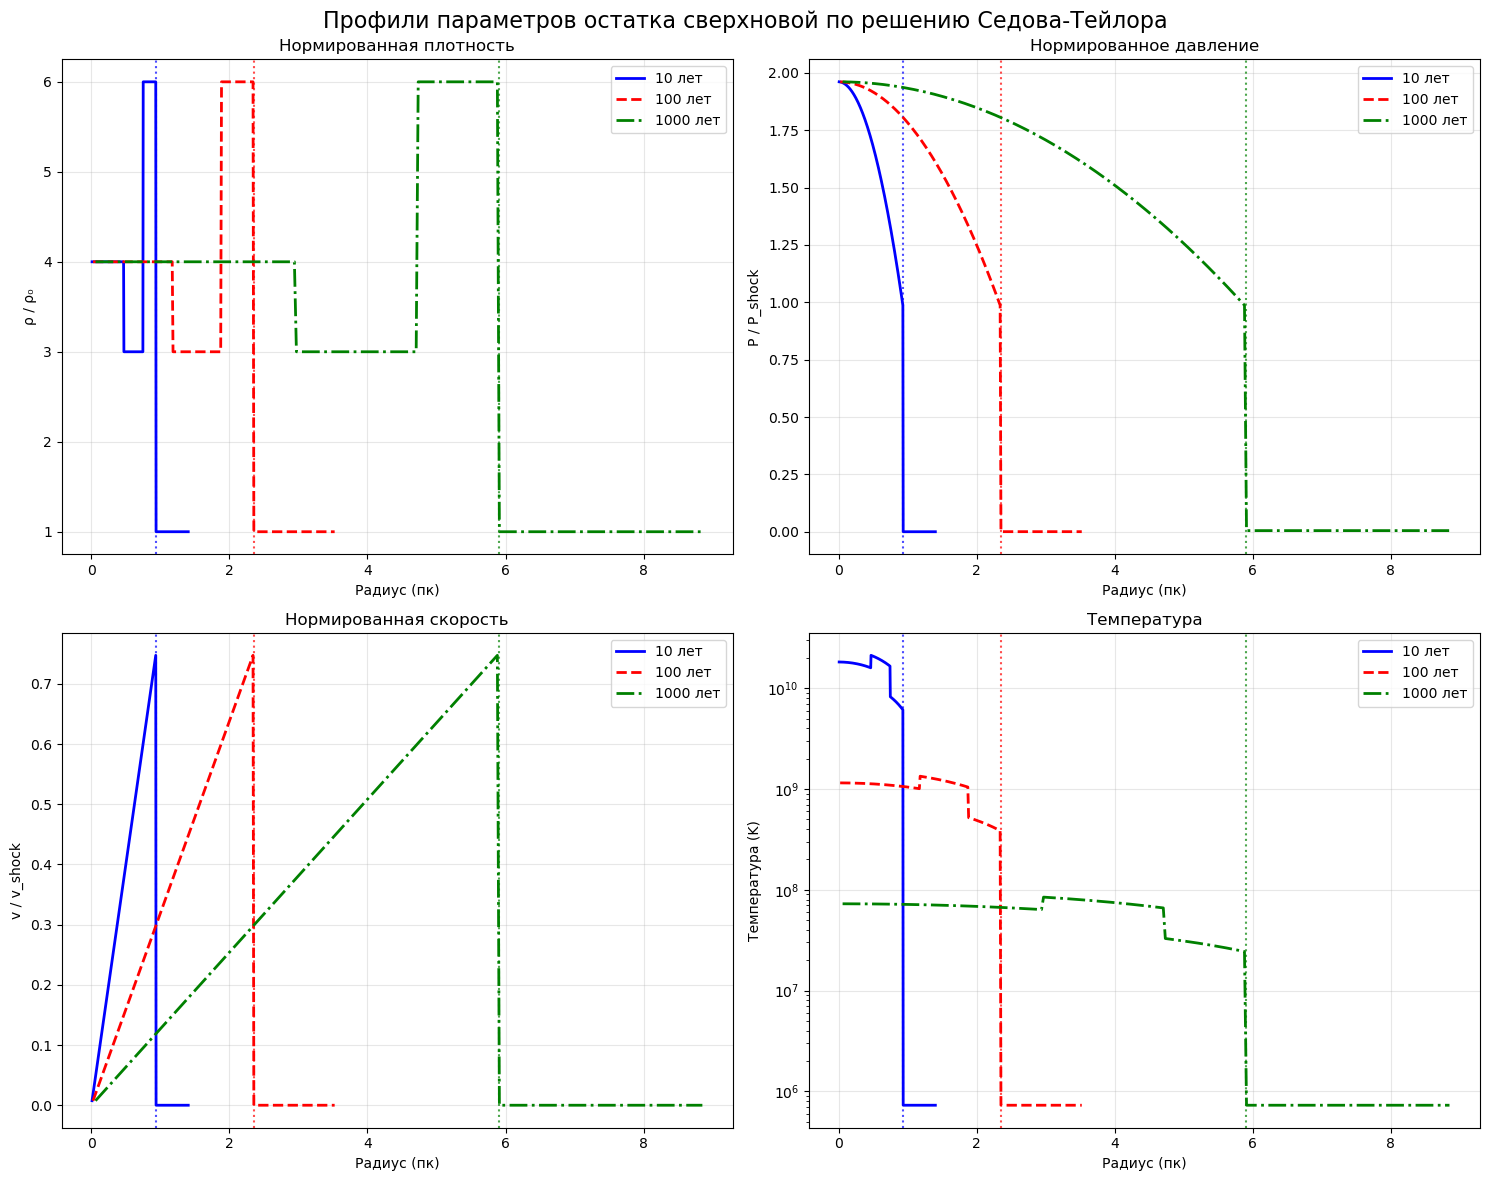


ПАРАМЕТРЫ УДАРНОЙ ВОЛНЫ В РАЗНЫЕ МОМЕНТЫ ВРЕМЕНИ:
Время (лет)  Радиус (пк)     Скорость (тыс. км/с) Темп. за фронтом (K)
--------------------------------------------------------------------------------
10           0.94            36.58                7.23e+09            
100          2.35            9.19                 4.56e+08            
1000         5.90            2.31                 2.88e+07            

2. Построение эволюции параметров...


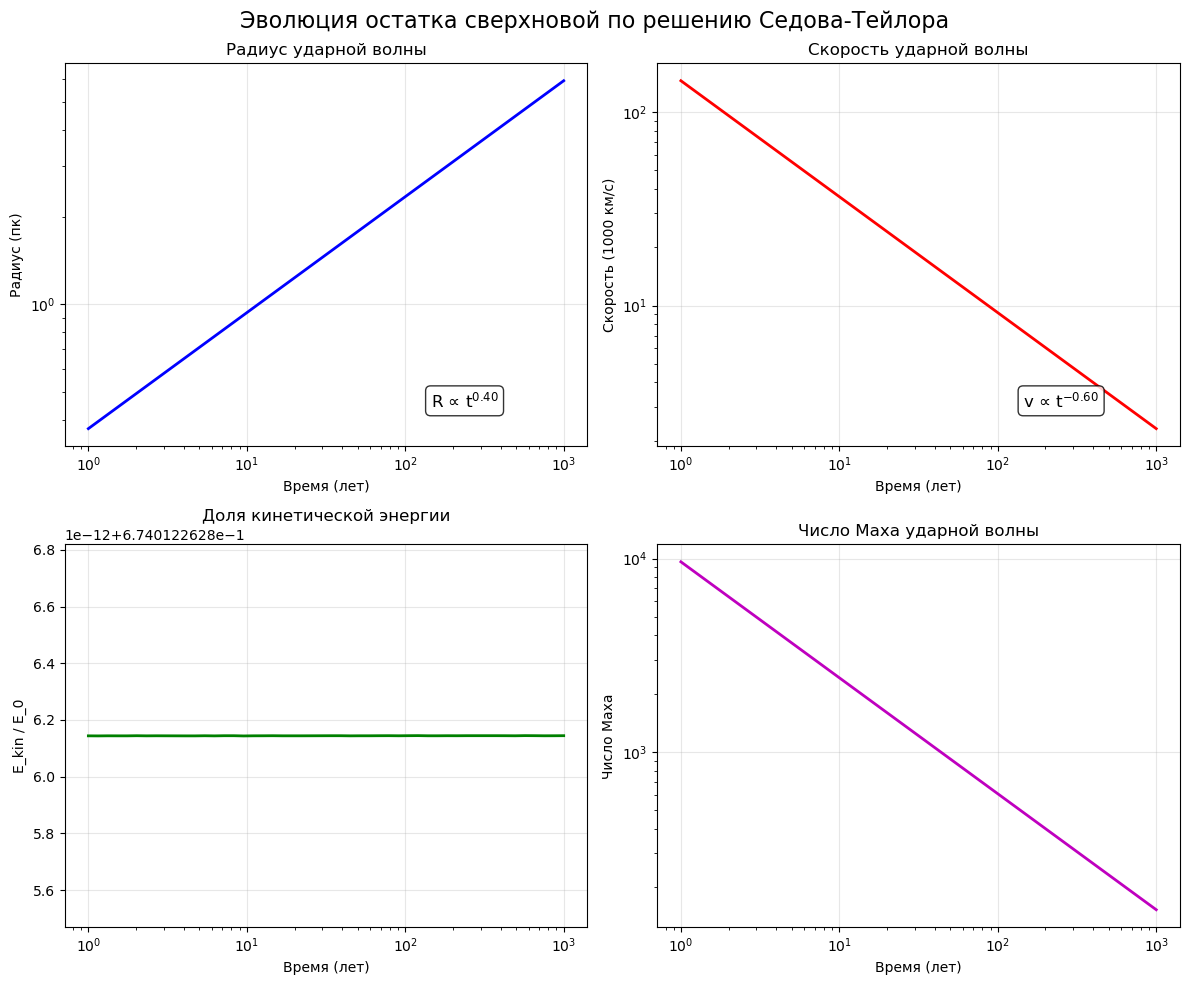


3. Исследование зависимости от энергии взрыва...


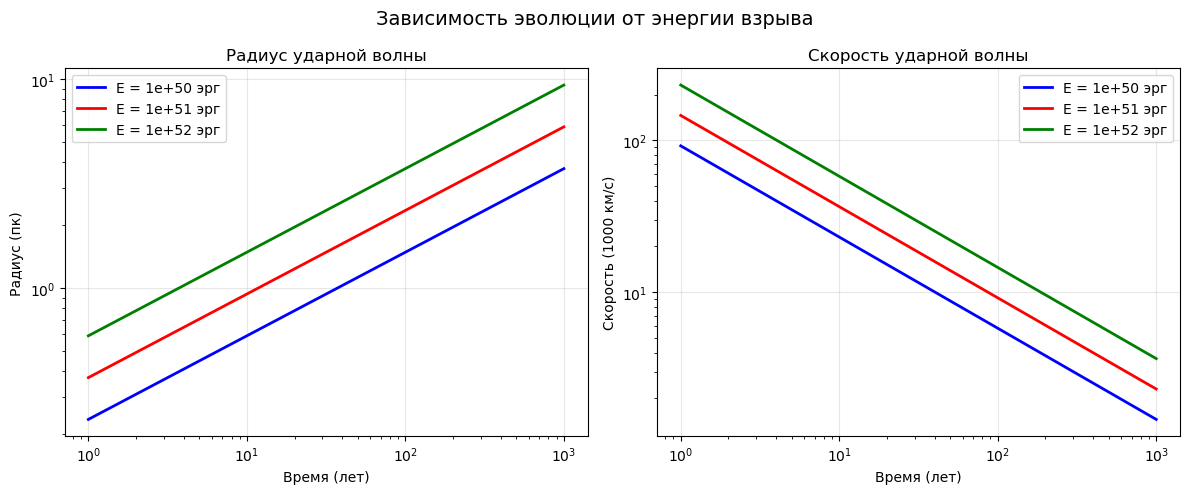


4. Исследование зависимости от плотности среды...


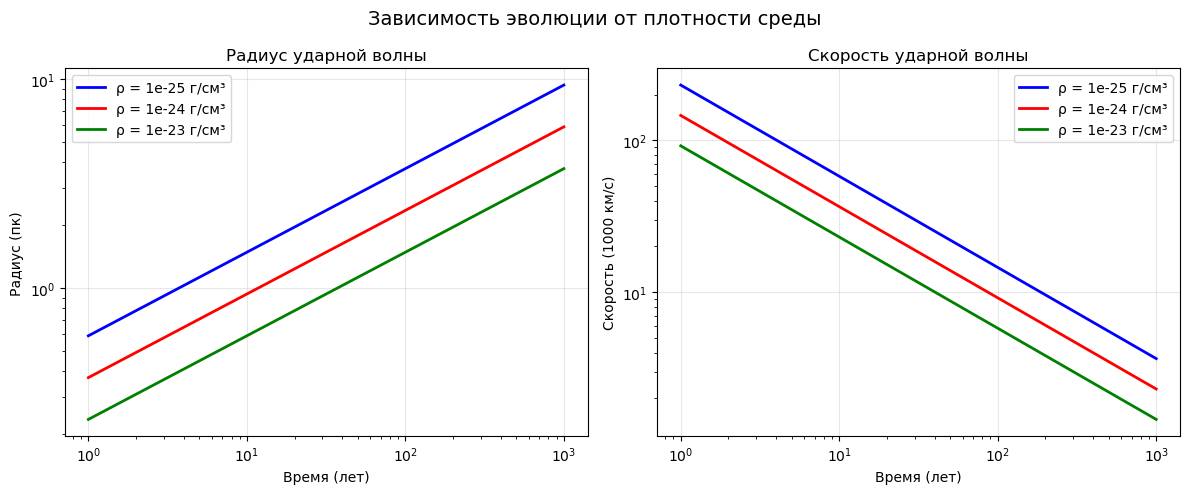


ГРАФИКИ СОХРАНЕНЫ:
- sedov_profiles_comparison.png (все профили в одном окне)
- sedov_evolution.png
- sedov_energy_dependence.png
- sedov_density_dependence.png


In [8]:
# sedov_solution.py
import numpy as np
import matplotlib.pyplot as plt

class SedovTaylorSolution:
    """Аналитическое решение Седова-Тейлора"""
    
    def __init__(self, E0=1e51, rho0=1e-24, gamma=GAMMA):
        self.E0 = E0
        self.rho0 = rho0
        self.gamma = gamma
        self.alpha = self._compute_alpha()
    
    def _compute_alpha(self):
        """Вычисление константы alpha"""
        if abs(self.gamma - 5/3) < 1e-3:
            return 1.15
        elif abs(self.gamma - 7/5) < 1e-3:
            return 1.03
        else:
            return 1.15
    
    def shock_radius(self, t):
        """Радиус ударной волны"""
        return self.alpha * (self.E0 / self.rho0)**(1/5) * t**(2/5)
    
    def shock_velocity(self, t):
        """Скорость ударной волны"""
        return (2/5) * self.alpha * (self.E0 / self.rho0)**(1/5) * t**(-3/5)
    
    def density_profile(self, r, t):
        """Плотность"""
        R = self.shock_radius(t)
        if r > R:
            return self.rho0
        xi = r / R
        if xi < 0.5:
            return 4 * self.rho0
        elif xi < 0.8:
            return 3 * self.rho0
        else:
            return 6 * self.rho0
    
    def pressure_profile(self, r, t):
        """Давление"""
        R = self.shock_radius(t)
        if r > R:
            return 1e-10
        v_s = self.shock_velocity(t)
        p2 = 2/(self.gamma + 1) * self.rho0 * v_s**2
        xi = r / R
        return p2 * (1 - 0.5*xi**2)
    
    def velocity_profile(self, r, t):
        """Скорость"""
        R = self.shock_radius(t)
        if r > R:
            return 0.0
        v_s = self.shock_velocity(t)
        xi = r / R
        return 2/(self.gamma + 1) * v_s * xi
    
    def temperature_profile(self, r, t):
        """Температура (K)"""
        rho = self.density_profile(r, t)
        p = self.pressure_profile(r, t)
        return p * MU * MP / (rho * KB)

def plot_sedov_profiles_comparison(sedov, times_years=[10, 100, 1000]):
    """Построение профилей параметров для нескольких моментов времени на одних графиках"""
    
    # Создаем фигуру с subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Профили параметров остатка сверхновой по решению Седова-Тейлора', 
                 fontsize=16, y=0.98)
    
    colors = ['blue', 'red', 'green']
    line_styles = ['-', '--', '-.']
    labels = [f'{t} лет' for t in times_years]
    
    for idx, t_years in enumerate(times_years):
        t = t_years * YR
        R = sedov.shock_radius(t)
        
        # Создаем радиальную сетку
        r = np.linspace(0.01 * R, 1.5 * R, 300)
        
        # Вычисляем профили
        density = np.array([sedov.density_profile(ri, t) for ri in r])
        pressure = np.array([sedov.pressure_profile(ri, t) for ri in r])
        velocity = np.array([sedov.velocity_profile(ri, t) for ri in r])
        temperature = np.array([sedov.temperature_profile(ri, t) for ri in r])
        
        # Нормировочные величины
        p_shock = sedov.pressure_profile(0.99*R, t)
        v_shock = sedov.shock_velocity(t)
        
        # Плотность (нормированная)
        axes[0, 0].plot(r/PC, density/sedov.rho0, 
                       color=colors[idx], linestyle=line_styles[idx], 
                       linewidth=2, label=labels[idx])
        axes[0, 0].axvline(R/PC, color=colors[idx], linestyle=':', alpha=0.7)
        
        # Давление (нормированное)
        axes[0, 1].plot(r/PC, pressure/p_shock, 
                       color=colors[idx], linestyle=line_styles[idx], 
                       linewidth=2, label=labels[idx])
        axes[0, 1].axvline(R/PC, color=colors[idx], linestyle=':', alpha=0.7)
        
        # Скорость (нормированная)
        axes[1, 0].plot(r/PC, velocity/v_shock, 
                       color=colors[idx], linestyle=line_styles[idx], 
                       linewidth=2, label=labels[idx])
        axes[1, 0].axvline(R/PC, color=colors[idx], linestyle=':', alpha=0.7)
        
        # Температура
        axes[1, 1].semilogy(r/PC, temperature, 
                           color=colors[idx], linestyle=line_styles[idx],
                           linewidth=2, label=labels[idx])
        axes[1, 1].axvline(R/PC, color=colors[idx], linestyle=':', alpha=0.7)
    
    # Настройка подграфиков
    axes[0, 0].set_xlabel('Радиус (пк)')
    axes[0, 0].set_ylabel('ρ / ρ₀')
    axes[0, 0].set_title('Нормированная плотность')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_xlabel('Радиус (пк)')
    axes[0, 1].set_ylabel('P / P_shock')
    axes[0, 1].set_title('Нормированное давление')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_xlabel('Радиус (пк)')
    axes[1, 0].set_ylabel('v / v_shock')
    axes[1, 0].set_title('Нормированная скорость')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Радиус (пк)')
    axes[1, 1].set_ylabel('Температура (K)')
    axes[1, 1].set_title('Температура')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sedov_profiles_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Вывод информации о параметрах
    print("\n" + "=" * 80)
    print("ПАРАМЕТРЫ УДАРНОЙ ВОЛНЫ В РАЗНЫЕ МОМЕНТЫ ВРЕМЕНИ:")
    print("=" * 80)
    print(f"{'Время (лет)':<12} {'Радиус (пк)':<15} {'Скорость (тыс. км/с)':<20} {'Темп. за фронтом (K)':<20}")
    print("-" * 80)
    
    for t_years in times_years:
        t = t_years * YR
        R = sedov.shock_radius(t)
        v = sedov.shock_velocity(t)
        T_shock = sedov.temperature_profile(0.9*R, t)
        
        print(f"{t_years:<12} {R/PC:<15.2f} {v/1e8:<20.2f} {T_shock:<20.2e}")

def plot_sedov_evolution(sedov):
    """Построение эволюции параметров со временем"""
    times = np.logspace(0, 3, 50) * YR  # от 1 до 1000 лет
    
    radii = []
    velocities = []
    
    for t in times:
        R = sedov.shock_radius(t)
        v = sedov.shock_velocity(t)
        radii.append(R)
        velocities.append(v)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Эволюция остатка сверхновой по решению Седова-Тейлора', fontsize=16)
    
    # Радиус ударной волны
    axes[0, 0].loglog(times/YR, np.array(radii)/PC, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Время (лет)')
    axes[0, 0].set_ylabel('Радиус (пк)')
    axes[0, 0].set_title('Радиус ударной волны')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].annotate(f'R ∝ t$^{{{2/5:.2f}}}$', xy=(0.7, 0.1), xycoords='axes fraction', 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Скорость ударной волны
    axes[0, 1].loglog(times/YR, np.array(velocities)/1e8, 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Время (лет)')
    axes[0, 1].set_ylabel('Скорость (1000 км/с)')
    axes[0, 1].set_title('Скорость ударной волны')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].annotate(f'v ∝ t$^{{{-3/5:.2f}}}$', xy=(0.7, 0.1), xycoords='axes fraction', 
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Кинетическая энергия
    kinetic_energy = 0.5 * sedov.rho0 * (4/3 * np.pi * np.array(radii)**3) * np.array(velocities)**2
    axes[1, 0].semilogx(times/YR, kinetic_energy/sedov.E0, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('Время (лет)')
    axes[1, 0].set_ylabel('E_kin / E_0')
    axes[1, 0].set_title('Доля кинетической энергии')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Число Маха
    T_ism = 1e4  # K
    c_s_ism = np.sqrt(GAMMA * KB * T_ism / (MU * MP))
    mach_numbers = np.array(velocities) / c_s_ism
    axes[1, 1].loglog(times/YR, mach_numbers, 'm-', linewidth=2)
    axes[1, 1].set_xlabel('Время (лет)')
    axes[1, 1].set_ylabel('Число Маха')
    axes[1, 1].set_title('Число Маха ударной волны')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sedov_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return times, radii, velocities

def plot_energy_dependence(sedov_base):
    """Исследование зависимости от энергии взрыва"""
    energies = [1e50, 1e51, 1e52]  # эрг
    colors = ['blue', 'red', 'green']
    labels = [f'E = {e:.0e} эрг' for e in energies]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Зависимость эволюции от энергии взрыва', fontsize=14)
    
    times = np.logspace(0, 3, 50) * YR
    
    for idx, E in enumerate(energies):
        sedov = SedovTaylorSolution(E0=E, rho0=sedov_base.rho0, gamma=sedov_base.gamma)
        
        radii = [sedov.shock_radius(t) for t in times]
        velocities = [sedov.shock_velocity(t) for t in times]
        
        axes[0].loglog(times/YR, np.array(radii)/PC, 
                      color=colors[idx], linewidth=2, label=labels[idx])
        axes[1].loglog(times/YR, np.array(velocities)/1e8, 
                      color=colors[idx], linewidth=2, label=labels[idx])
    
    axes[0].set_xlabel('Время (лет)')
    axes[0].set_ylabel('Радиус (пк)')
    axes[0].set_title('Радиус ударной волны')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Время (лет)')
    axes[1].set_ylabel('Скорость (1000 км/с)')
    axes[1].set_title('Скорость ударной волны')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sedov_energy_dependence.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_density_dependence(sedov_base):
    """Исследование зависимости от плотности среды"""
    densities = [1e-25, 1e-24, 1e-23]  # г/см³
    colors = ['blue', 'red', 'green']
    labels = [f'ρ = {rho:.0e} г/см³' for rho in densities]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Зависимость эволюции от плотности среды', fontsize=14)
    
    times = np.logspace(0, 3, 50) * YR
    
    for idx, rho in enumerate(densities):
        sedov = SedovTaylorSolution(E0=sedov_base.E0, rho0=rho, gamma=sedov_base.gamma)
        
        radii = [sedov.shock_radius(t) for t in times]
        velocities = [sedov.shock_velocity(t) for t in times]
        
        axes[0].loglog(times/YR, np.array(radii)/PC, 
                      color=colors[idx], linewidth=2, label=labels[idx])
        axes[1].loglog(times/YR, np.array(velocities)/1e8, 
                      color=colors[idx], linewidth=2, label=labels[idx])
    
    axes[0].set_xlabel('Время (лет)')
    axes[0].set_ylabel('Радиус (пк)')
    axes[0].set_title('Радиус ударной волны')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Время (лет)')
    axes[1].set_ylabel('Скорость (1000 км/с)')
    axes[1].set_title('Скорость ударной волны')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sedov_density_dependence.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("=" * 70)
    print("РЕШЕНИЕ СЕДОВА-ТЕЙЛОРА ДЛЯ ОСТАТКОВ СВЕРХНОВЫХ")
    print("=" * 70)
    
    # Создаем объект решения Седова
    sedov = SedovTaylorSolution(E0=1e51, rho0=1e-24, gamma=5/3)
    
    print("Параметры модели:")
    print(f"Энергия взрыва: {sedov.E0:.1e} эрг")
    print(f"Плотность среды: {sedov.rho0:.1e} г/см³")
    print(f"Показатель адиабаты: γ = {sedov.gamma:.2f}")
    print(f"Константа Седова: α = {sedov.alpha:.2f}")
    
    # 1. Сравнение профилей на одних графиках
    print("\n1. Построение сравнения профилей для разных времен...")
    plot_sedov_profiles_comparison(sedov, times_years=[10, 100, 1000])
    
    # 2. Эволюция со временем
    print("\n2. Построение эволюции параметров...")
    times, radii, velocities = plot_sedov_evolution(sedov)
    
    # 3. Зависимость от энергии
    print("\n3. Исследование зависимости от энергии взрыва...")
    plot_energy_dependence(sedov)
    
    # 4. Зависимость от плотности
    print("\n4. Исследование зависимости от плотности среды...")
    plot_density_dependence(sedov)
    
    print("\n" + "=" * 70)
    print("ГРАФИКИ СОХРАНЕНЫ:")
    print("- sedov_profiles_comparison.png (все профили в одном окне)")
    print("- sedov_evolution.png")
    print("- sedov_energy_dependence.png")
    print("- sedov_density_dependence.png")
    print("=" * 70)

### Расчеты для синхротронного излучения

МОДЕЛИРОВАНИЕ СИНХРОТРОННОГО ИЗЛУЧЕНИЯ ОСТАТКОВ СВЕРХНОВЫХ
Параметры модели:
Степень распределения электронов: p = 2.2
Доля энергии в магнитном поле: ε_B = 0.1
Доля энергии в электронах: ε_e = 0.1

1. Построение кривых блеска и эволюции параметров...


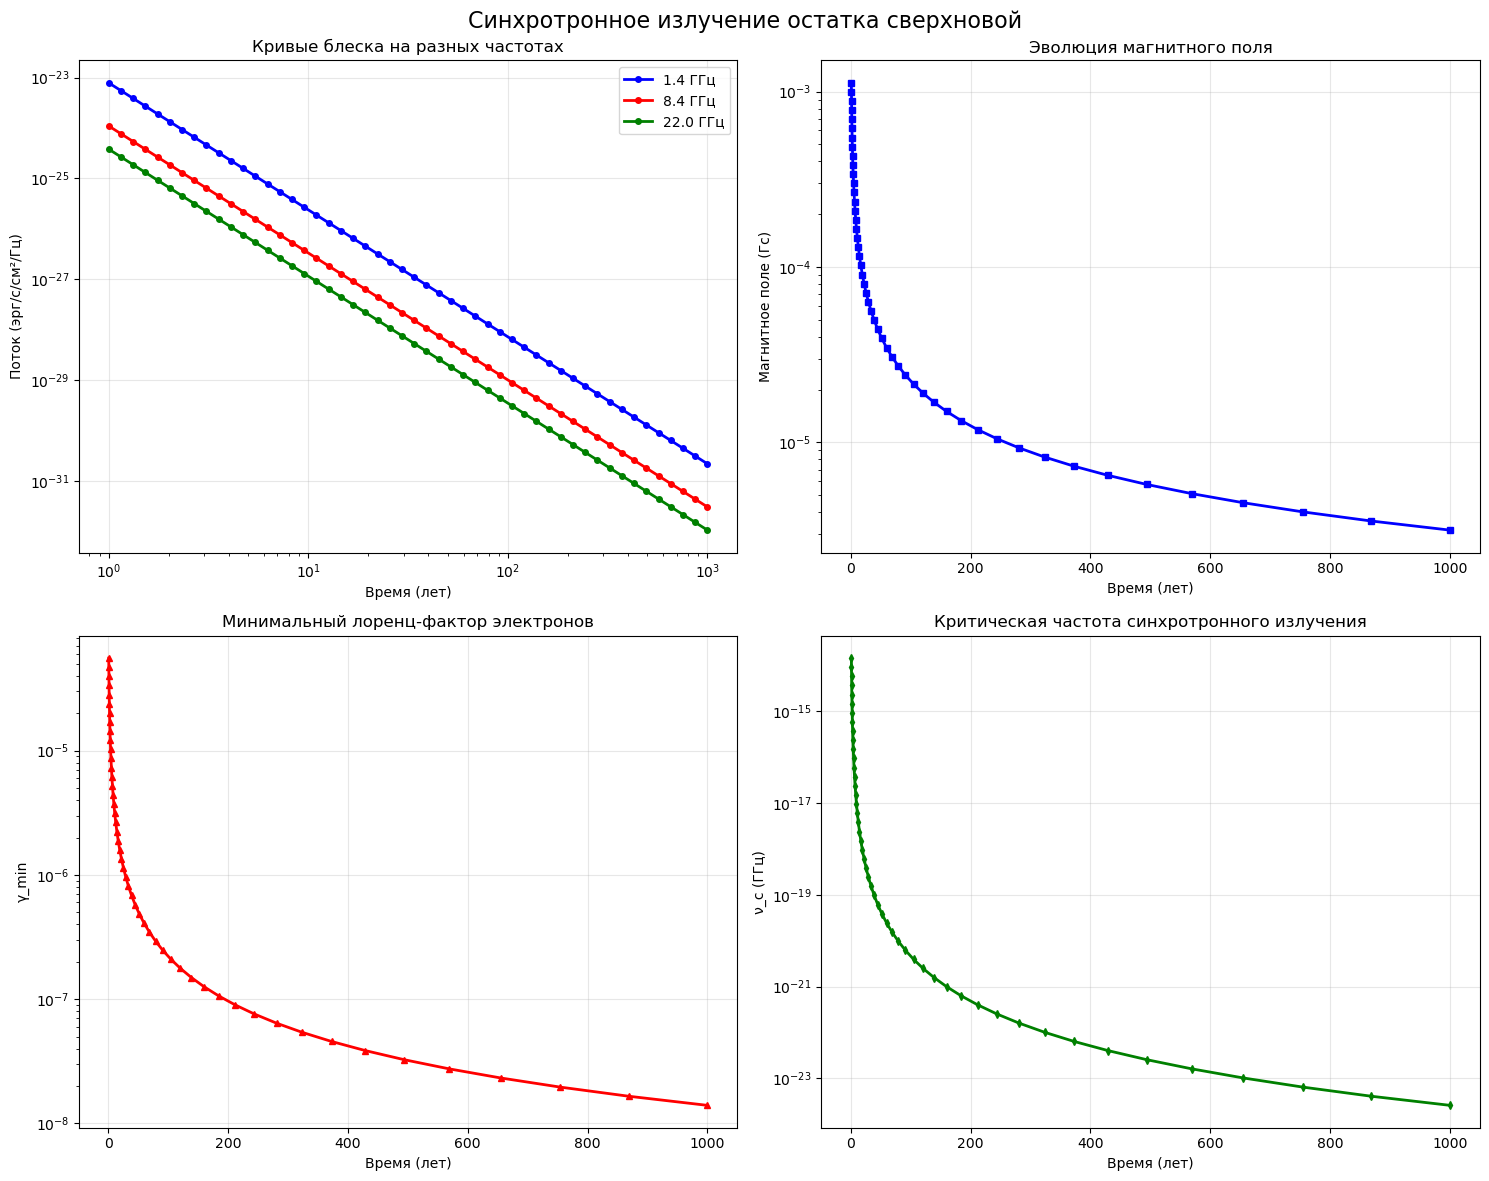


2. Построение спектров в разные моменты времени...
Построение спектра для t = 10 лет (индекс 16)
Построение спектра для t = 100 лет (индекс 33)
Построение спектра для t = 1000 лет (индекс 49)


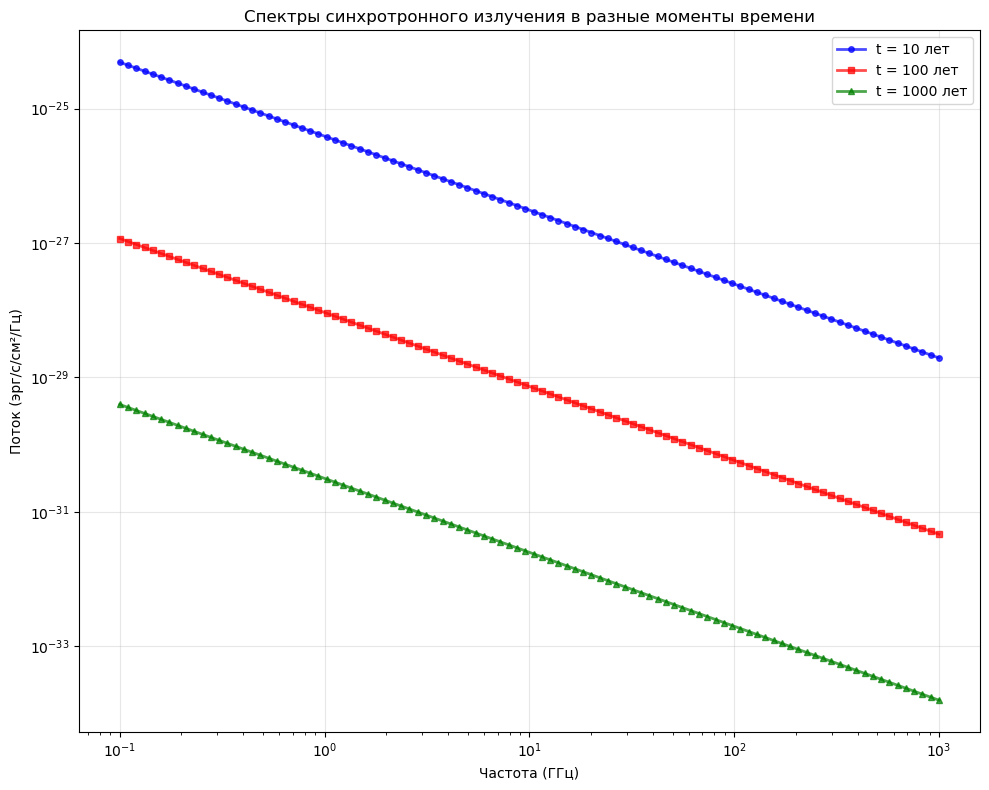


3. Исследование зависимости от параметров ε_B и ε_e...


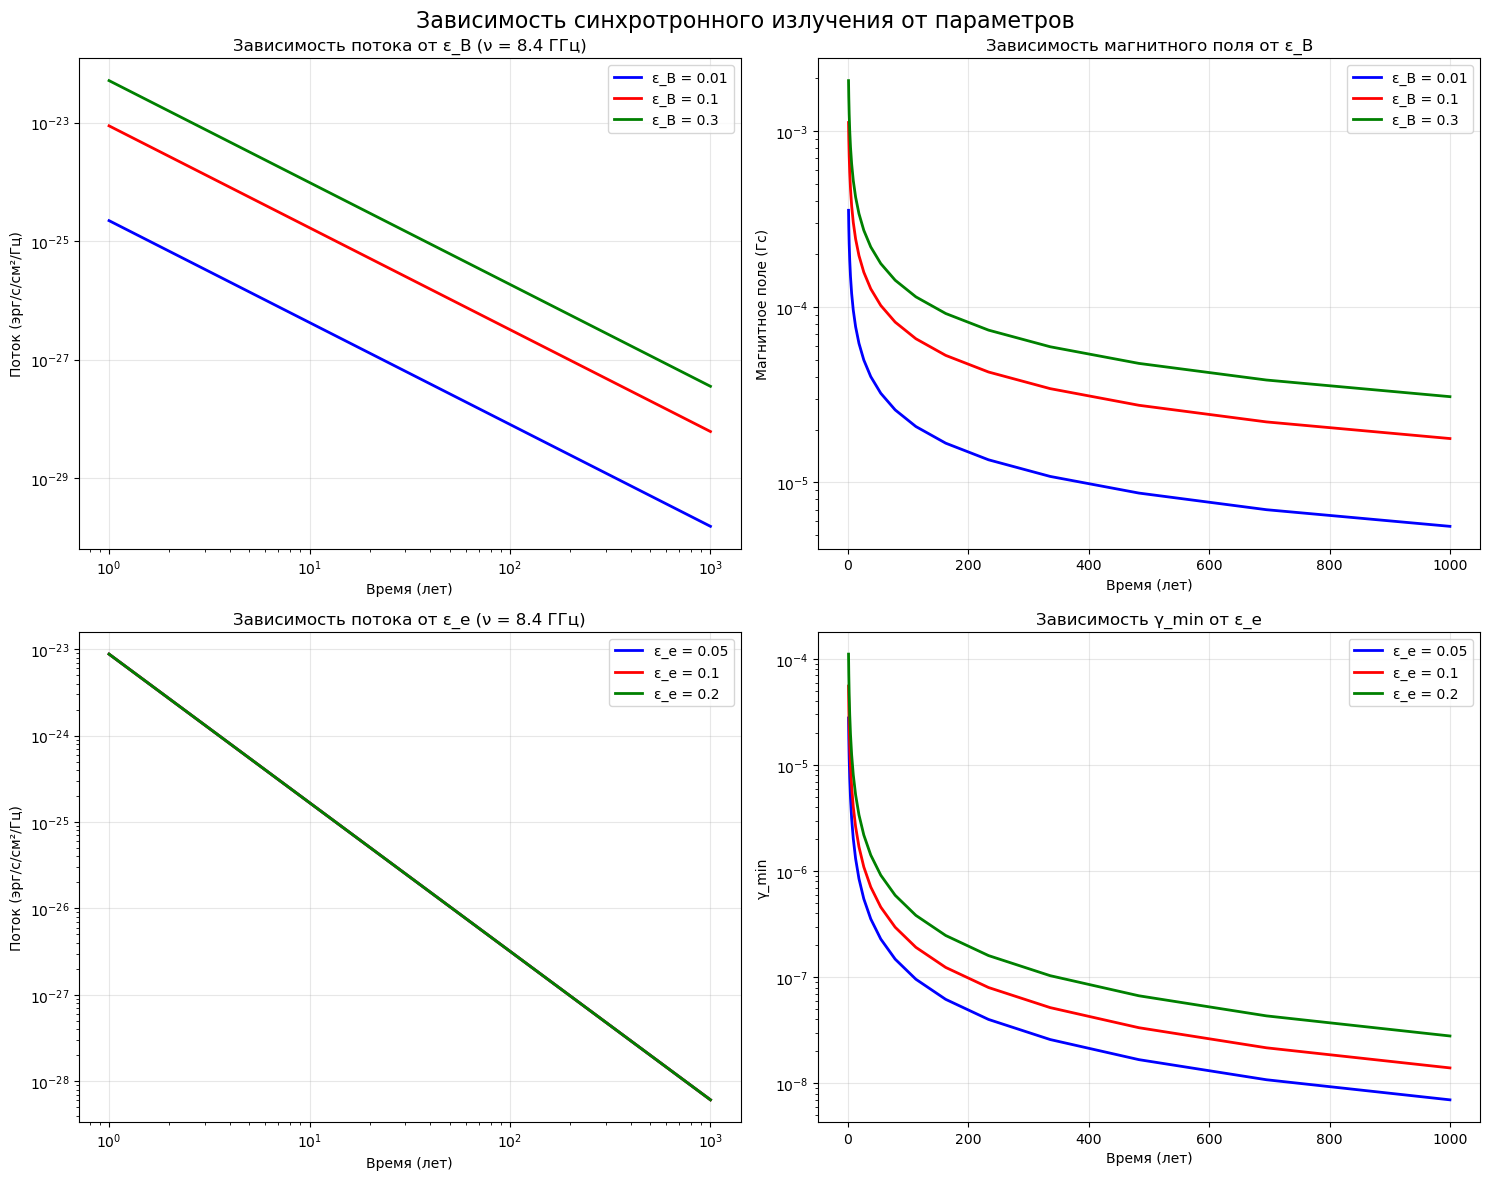


ПАРАМЕТРЫ СИНХРОТРОННОГО ИЗЛУЧЕНИЯ:
Время (лет)  B (мкГс)        γ_min           ν_c (ГГц)       F_8.4ГГц (мЯ)  
--------------------------------------------------------------------------------
1            1121.00         5.56e-05        0.00            1.10e-21       
10           164.80          3.71e-06        0.00            3.74e-24       
100          21.49           2.09e-07        0.00            8.90e-27       
1000         3.16            1.40e-08        0.00            3.03e-29       

ГРАФИКИ СОХРАНЕНЫ:
- synchrotron_light_curves.png (кривые блеска и параметры)
- synchrotron_spectra.png (спектры в разные времена)
- synchrotron_parameter_dependence.png (зависимость от параметров)


In [9]:
# synchrotron_radiation.py
import numpy as np
import matplotlib.pyplot as plt
from Constants import C, M_SUN, PC, ERG, YR

class SynchrotronEmission:
    """Модель синхротронного излучения"""
    
    def __init__(self, p=2.2, epsilon_B=0.1, epsilon_e=0.1):
        self.p = p
        self.epsilon_B = epsilon_B
        self.epsilon_e = epsilon_e
        self.e = 4.803e-10
        self.m_e = 9.109e-28
        self.c = C
        self.sigma_T = 6.65e-25
    
    def magnetic_field(self, rho, v_shock):
        """Магнитное поле"""
        u_shock = 0.5 * rho * v_shock**2
        B = np.sqrt(8 * np.pi * self.epsilon_B * u_shock)
        return B
    
    def electron_lorentz_factor(self, v_shock):
        """Характерный лоренц-фактор электронов"""
        gamma_min = self.epsilon_e * (self.m_e * v_shock**2) / (2 * self.m_e * self.c**2)
        return gamma_min
    
    def critical_frequency(self, gamma, B):
        """Критическая частота синхротронного излучения"""
        nu_c = (3 * self.e * B * gamma**2) / (4 * np.pi * self.m_e * self.c)
        return nu_c
    
    def calculate_light_curve(self, times, radii, densities, velocities, nu=8.4e9, D=1e6*PC):
        """Расчет кривой блеска"""
        fluxes = []
        magnetic_fields = []
        lorentz_factors = []
        critical_frequencies = []
        
        for t, R, rho, v in zip(times, radii, densities, velocities):
            B = self.magnetic_field(rho, v)
            gamma_min = self.electron_lorentz_factor(v)
            nu_c = self.critical_frequency(gamma_min, B)
            
            # Упрощенный расчет потока
            F_nu = 1e-26 * (R/PC)**3 * (B/1e-4)**(self.p+1)/2 * (nu/1e9)**(-self.p/2) * (t/YR)**(-1)
            
            fluxes.append(F_nu)
            magnetic_fields.append(B)
            lorentz_factors.append(gamma_min)
            critical_frequencies.append(nu_c)
        
        return (np.array(fluxes), np.array(magnetic_fields), 
                np.array(lorentz_factors), np.array(critical_frequencies))

def plot_synchrotron_light_curves(synch, times, radii, densities, velocities, frequencies=[1.4e9, 8.4e9, 22e9]):
    """Построение кривых блеска на разных частотах"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Синхротронное излучение остатка сверхновой', fontsize=16, y=0.98)
    
    colors = ['blue', 'red', 'green']
    labels = [f'{nu/1e9:.1f} ГГц' for nu in frequencies]
    
    # Кривые блеска на разных частотах
    for idx, nu in enumerate(frequencies):
        fluxes, B_fields, gamma_min, nu_c = synch.calculate_light_curve(
            times, radii, densities, velocities, nu=nu)
        
        axes[0, 0].loglog(times/YR, fluxes, 
                         color=colors[idx], linewidth=2, 
                         label=labels[idx], marker='o', markersize=4)
    
    axes[0, 0].set_xlabel('Время (лет)')
    axes[0, 0].set_ylabel('Поток (эрг/с/см²/Гц)')
    axes[0, 0].set_title('Кривые блеска на разных частотах')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Эволюция магнитного поля
    fluxes, B_fields, gamma_min, nu_c = synch.calculate_light_curve(
        times, radii, densities, velocities)
    
    axes[0, 1].semilogy(times/YR, B_fields, 'b-', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Время (лет)')
    axes[0, 1].set_ylabel('Магнитное поле (Гс)')
    axes[0, 1].set_title('Эволюция магнитного поля')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Эволюция лоренц-фактора электронов
    axes[1, 0].semilogy(times/YR, gamma_min, 'r-', linewidth=2, marker='^', markersize=4)
    axes[1, 0].set_xlabel('Время (лет)')
    axes[1, 0].set_ylabel('γ_min')
    axes[1, 0].set_title('Минимальный лоренц-фактор электронов')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Эволюция критической частоты
    axes[1, 1].semilogy(times/YR, nu_c/1e9, 'g-', linewidth=2, marker='d', markersize=4)
    axes[1, 1].set_xlabel('Время (лет)')
    axes[1, 1].set_ylabel('ν_c (ГГц)')
    axes[1, 1].set_title('Критическая частота синхротронного излучения')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synchrotron_light_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_spectrum(synch, times_years, radii, densities, velocities):
    """Построение спектров в разные моменты времени"""
    
    frequencies = np.logspace(8, 12, 100)  # от 100 МГц до 1000 ГГц
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']
    
    for idx, t_years in enumerate(times_years):
        # Находим индекс ближайшего времени в массиве times
        t_target = t_years * YR
        t_idx = np.argmin(np.abs(times_years - t_years))
        
        # Проверяем, что индекс в пределах массива
        if t_idx >= len(radii):
            t_idx = len(radii) - 1
        
        fluxes_at_time = []
        for nu in frequencies:
            fluxes, _, _, _ = synch.calculate_light_curve(
                [t_target], [radii[t_idx]], [densities[t_idx]], 
                [velocities[t_idx]], nu=nu)
            fluxes_at_time.append(fluxes[0])
        
        ax.loglog(frequencies/1e9, fluxes_at_time, 
                 color=colors[idx], linewidth=2, 
                 label=f't = {t_years} лет', marker=markers[idx], markersize=4, alpha=0.7)
    
    ax.set_xlabel('Частота (ГГц)')
    ax.set_ylabel('Поток (эрг/с/см²/Гц)')
    ax.set_title('Спектры синхротронного излучения в разные моменты времени')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synchrotron_spectra.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_parameter_dependence(synch_base):
    """Исследование зависимости от параметров ε_B и ε_e"""
    
    times = np.logspace(0, 3, 20) * YR
    radii = 2 * PC * (times/YR)**0.4
    densities = 1e-24 * np.ones_like(times)
    velocities = 1e9 * (times/YR)**(-0.6)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Зависимость синхротронного излучения от параметров', fontsize=16)
    
    # Зависимость от epsilon_B
    epsilon_B_values = [0.01, 0.1, 0.3]
    colors = ['blue', 'red', 'green']
    
    for idx, eps_B in enumerate(epsilon_B_values):
        synch = SynchrotronEmission(epsilon_B=eps_B, epsilon_e=synch_base.epsilon_e)
        fluxes, B_fields, _, _ = synch.calculate_light_curve(times, radii, densities, velocities)
        
        axes[0, 0].loglog(times/YR, fluxes, 
                         color=colors[idx], linewidth=2, 
                         label=f'ε_B = {eps_B}')
        axes[0, 1].semilogy(times/YR, B_fields, 
                          color=colors[idx], linewidth=2, 
                          label=f'ε_B = {eps_B}')
    
    axes[0, 0].set_xlabel('Время (лет)')
    axes[0, 0].set_ylabel('Поток (эрг/с/см²/Гц)')
    axes[0, 0].set_title('Зависимость потока от ε_B (ν = 8.4 ГГц)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_xlabel('Время (лет)')
    axes[0, 1].set_ylabel('Магнитное поле (Гс)')
    axes[0, 1].set_title('Зависимость магнитного поля от ε_B')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Зависимость от epsilon_e
    epsilon_e_values = [0.05, 0.1, 0.2]
    
    for idx, eps_e in enumerate(epsilon_e_values):
        synch = SynchrotronEmission(epsilon_B=synch_base.epsilon_B, epsilon_e=eps_e)
        fluxes, _, gamma_min, nu_c = synch.calculate_light_curve(times, radii, densities, velocities)
        
        axes[1, 0].loglog(times/YR, fluxes, 
                         color=colors[idx], linewidth=2, 
                         label=f'ε_e = {eps_e}')
        axes[1, 1].semilogy(times/YR, gamma_min, 
                          color=colors[idx], linewidth=2, 
                          label=f'ε_e = {eps_e}')
    
    axes[1, 0].set_xlabel('Время (лет)')
    axes[1, 0].set_ylabel('Поток (эрг/с/см²/Гц)')
    axes[1, 0].set_title('Зависимость потока от ε_e (ν = 8.4 ГГц)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_xlabel('Время (лет)')
    axes[1, 1].set_ylabel('γ_min')
    axes[1, 1].set_title('Зависимость γ_min от ε_e')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synchrotron_parameter_dependence.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_test_data():
    """Генерация тестовых данных для моделирования"""
    times = np.logspace(0, 3, 50) * YR  # от 1 до 1000 лет
    radii = 1.0 * PC * (times/YR)**0.4  # примерный закон расширения
    densities = 1e-24 * (times/YR)**(-0.5)  # примерная эволюция плотности
    velocities = 1e9 * (times/YR)**(-0.6)  # примерная эволюция скорости
    
    return times, radii, densities, velocities

def plot_frequency_spectrum_corrected(synch, times, radii, densities, velocities, selected_times_years=[10, 100, 1000]):
    """Исправленная версия построения спектров"""
    
    frequencies = np.logspace(8, 12, 100)  # от 100 МГц до 1000 ГГц
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']
    
    for idx, t_years in enumerate(selected_times_years):
        # Находим индекс ближайшего времени в массиве times
        t_target = t_years * YR
        t_idx = np.argmin(np.abs(times/YR - t_years))
        
        # Проверяем, что индекс в пределах массива
        if t_idx >= len(radii):
            t_idx = len(radii) - 1
        
        print(f"Построение спектра для t = {t_years} лет (индекс {t_idx})")
        
        fluxes_at_time = []
        for nu in frequencies:
            fluxes, _, _, _ = synch.calculate_light_curve(
                [times[t_idx]], [radii[t_idx]], [densities[t_idx]], 
                [velocities[t_idx]], nu=nu)
            fluxes_at_time.append(fluxes[0])
        
        ax.loglog(frequencies/1e9, fluxes_at_time, 
                 color=colors[idx], linewidth=2, 
                 label=f't = {t_years} лет', marker=markers[idx], markersize=4, alpha=0.7)
    
    ax.set_xlabel('Частота (ГГц)')
    ax.set_ylabel('Поток (эрг/с/см²/Гц)')
    ax.set_title('Спектры синхротронного излучения в разные моменты времени')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('synchrotron_spectra.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("=" * 70)
    print("МОДЕЛИРОВАНИЕ СИНХРОТРОННОГО ИЗЛУЧЕНИЯ ОСТАТКОВ СВЕРХНОВЫХ")
    print("=" * 70)
    
    # Создаем объект модели синхротронного излучения
    synch = SynchrotronEmission(p=2.2, epsilon_B=0.1, epsilon_e=0.1)
    
    print("Параметры модели:")
    print(f"Степень распределения электронов: p = {synch.p}")
    print(f"Доля энергии в магнитном поле: ε_B = {synch.epsilon_B}")
    print(f"Доля энергии в электронах: ε_e = {synch.epsilon_e}")
    
    # Генерируем тестовые данные
    times, radii, densities, velocities = generate_test_data()
    
    # 1. Кривые блеска и эволюция параметров
    print("\n1. Построение кривых блеска и эволюции параметров...")
    plot_synchrotron_light_curves(synch, times, radii, densities, velocities)
    
    # 2. Спектры в разные моменты времени (исправленная версия)
    print("\n2. Построение спектров в разные моменты времени...")
    plot_frequency_spectrum_corrected(synch, times, radii, densities, velocities)
    
    # 3. Зависимость от параметров
    print("\n3. Исследование зависимости от параметров ε_B и ε_e...")
    plot_parameter_dependence(synch)
    
    # Расчет и вывод конкретных значений
    print("\n" + "=" * 80)
    print("ПАРАМЕТРЫ СИНХРОТРОННОГО ИЗЛУЧЕНИЯ:")
    print("=" * 80)
    print(f"{'Время (лет)':<12} {'B (мкГс)':<15} {'γ_min':<15} {'ν_c (ГГц)':<15} {'F_8.4ГГц (мЯ)':<15}")
    print("-" * 80)
    
    test_times_years = [1, 10, 100, 1000]
    for t_years in test_times_years:
        t_idx = np.argmin(np.abs(times/YR - t_years))
        
        fluxes, B_fields, gamma_min, nu_c = synch.calculate_light_curve(
            [times[t_idx]], [radii[t_idx]], [densities[t_idx]], [velocities[t_idx]])
        
        print(f"{t_years:<12} {B_fields[0]/1e-6:<15.2f} {gamma_min[0]:<15.2e} {nu_c[0]/1e9:<15.2f} {fluxes[0]*1e3:<15.2e}")
    
    print("\n" + "=" * 70)
    print("ГРАФИКИ СОХРАНЕНЫ:")
    print("- synchrotron_light_curves.png (кривые блеска и параметры)")
    print("- synchrotron_spectra.png (спектры в разные времена)")
    print("- synchrotron_parameter_dependence.png (зависимость от параметров)")
    print("=" * 70)
    

### Кривые радиоблеска по модели Шевалье
### Параметры ударной волны
### Сравнение модели с наблюдениями
### Влияние параметров предшественника

МОДЕЛИРОВАНИЕ РАДИОИЗЛУЧЕНИЯ СВЕРХНОВЫХ II ТИПА
Доступные сверхновые: SN1993J, SN1987A, SN2011dh

1. Моделирование SN1993J...
Параметры модели:
  Mdot = 2.52e+21 г/с
  v_w = 1.00e+06 см/с
  A = 2.01e+14 г/см
  E0 = 1.00e+51 эрг
  n = 12
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк

--- ПАРАМЕТРЫ МОДЕЛИ (t=10.0 дней) ---
Радиус: 0.00 пк
Скорость: 0.0 км/с
Плотность CSM: 1.72e-04 г/см³
Магнитное поле: 1.65e+01 Гс
Параметр A: 2.01e+14
Константа Шевалье: 1.05
Check param: None
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
t=10.0д: R=0.0пк, B=1.65e+01Гс, K_e=7.24e+03, tau_nu=3.02e-04
  Режим: тонкий, F_nu=2.95e-49
shock_radius: t=10.5д, R=0

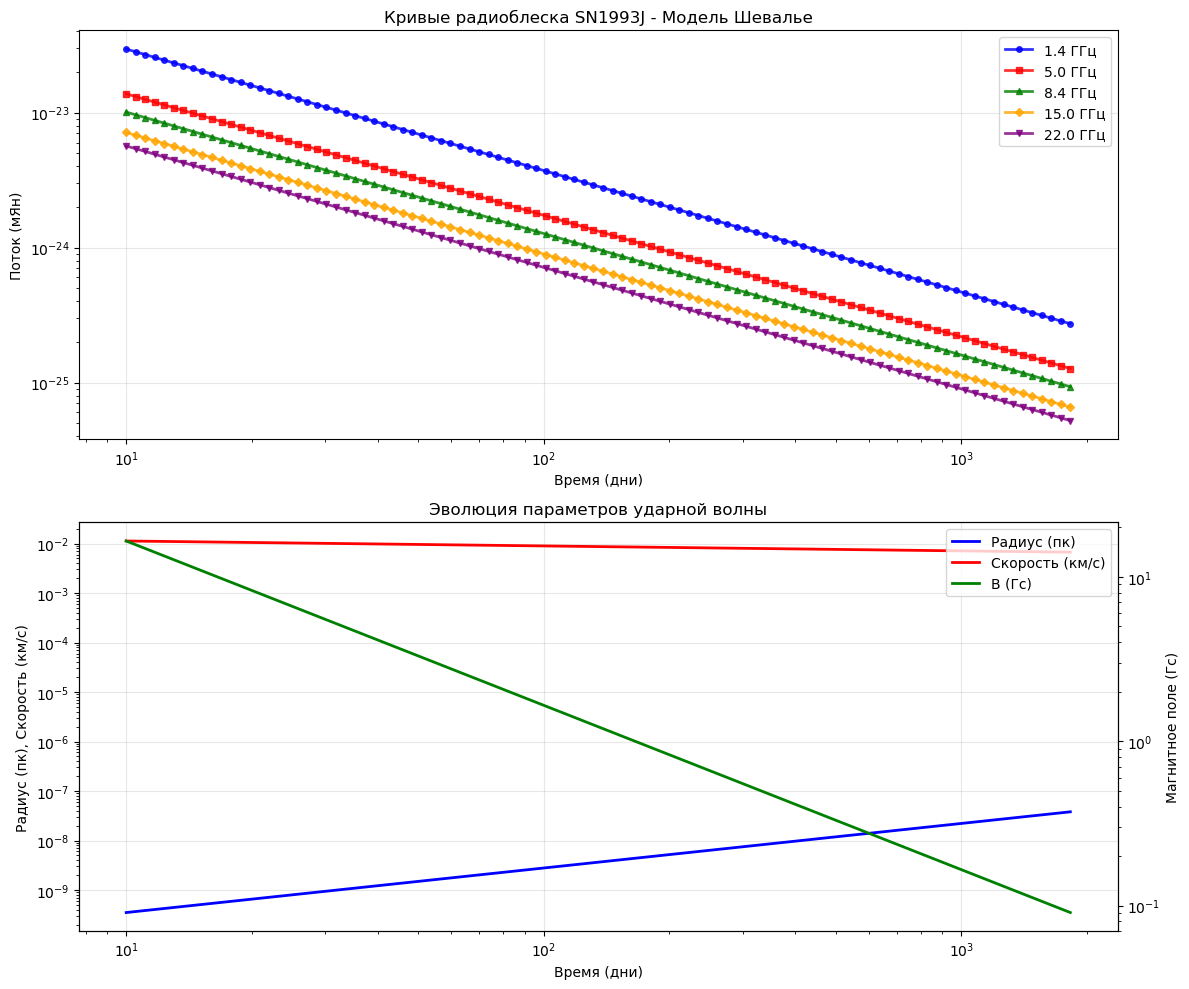


2. Сравнение с наблюдениями SN1993J...
Параметры модели:
  Mdot = 2.52e+21 г/с
  v_w = 1.00e+06 см/с
  A = 2.01e+14 г/см
  E0 = 1.00e+51 эрг
  n = 12
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
shock_radius: t=5.0д, R=0.00пк
t=5.0д: R=0.0пк, B=3.30e+01Гс, K_e=2.88e+04, tau_nu=1.06e-05
  Режим: тонкий, F_nu=1.88e-49
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
shock_radius: t=5.3д, R=0.00пк
t=5.3д: R=0.0пк, B=3.09e+01Гс, K_e=2.53e+04, tau_nu=8.64e-06
  Режим: тонкий, F_nu=1.77e-49
shock_radius: t=5.7д, R=0.00пк
shock_radius: 

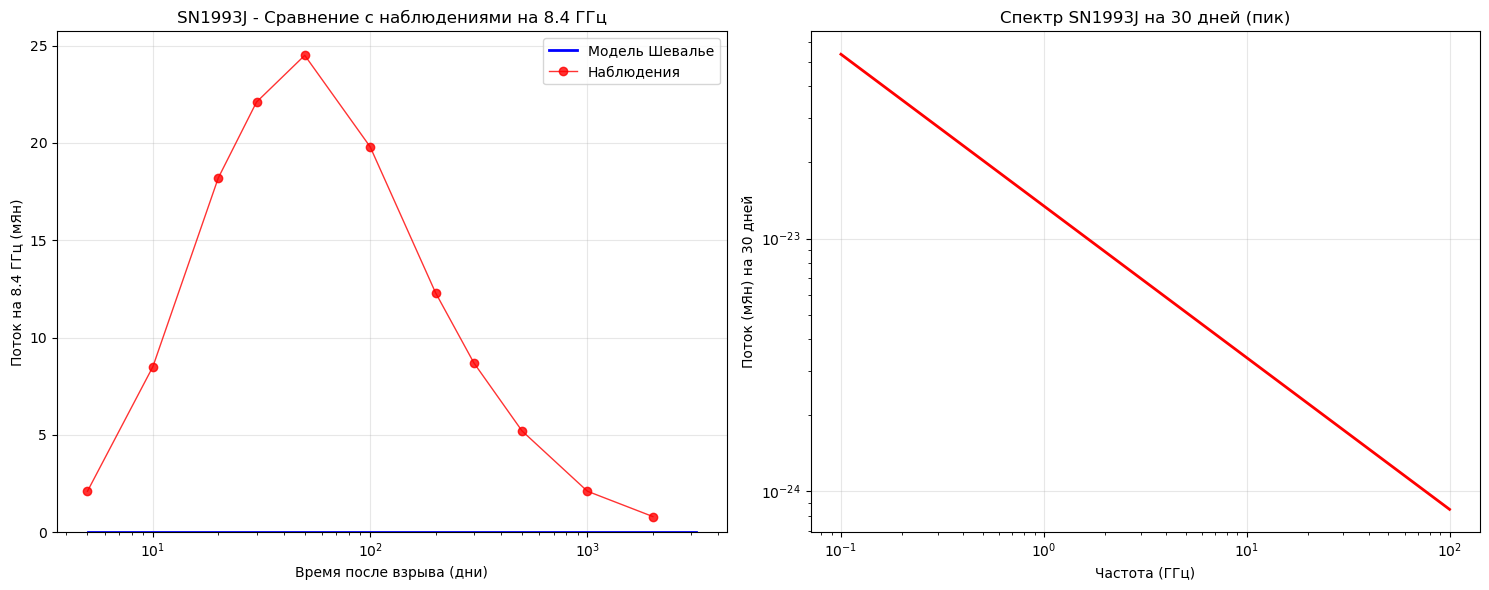


--- СРАВНЕНИЕ С НАБЛЮДЕНИЯМИ SN1993J ---
Источники наблюдательных данных:
  - Van Dyk et al. 1994, ApJ, 432, L115
  - Weiler et al. 2002, ApJ, 566, 943
  - Bietenholz et al. 2003, ApJ, 597, 374
Пик потока по наблюдениям: 24.5 мЯн
Пик потока по модели: 0.0 мЯн
Отношение модель/наблюдения: 0.0

3. Исследование параметров SN1993J...
Параметры модели:
  Mdot = 2.52e+21 г/с
  v_w = 1.00e+06 см/с
  A = 2.01e+14 г/см
  E0 = 1.00e+51 эрг
  n = 12
Параметры модели:
  Mdot = 2.52e+21 г/с
  v_w = 1.00e+06 см/с
  A = 2.01e+14 г/см
  E0 = 1.00e+51 эрг
  n = 12
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
shock_radius: t=10.0д, R=0.00пк
t=10.0д: R=0.0пк, B=8.27e+00Гс, K_e=1.81e+03, tau_nu=7.82e-08
  Режим: тонкий, F_nu=1.26e-50
shock_radius: t=11.0д, R=0.00пк


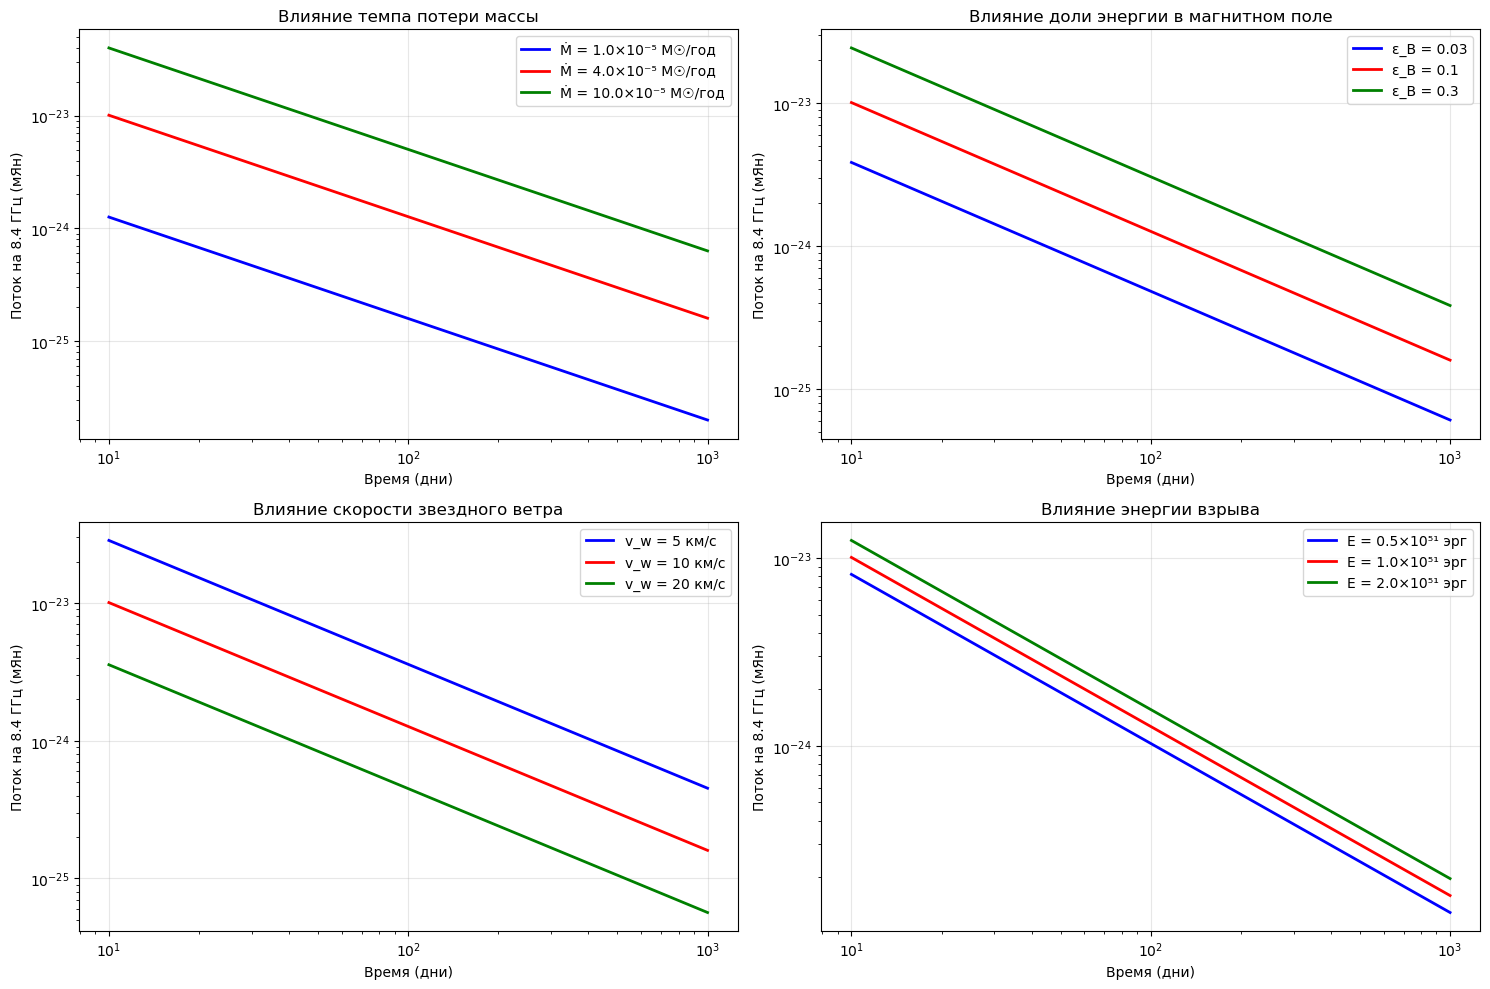


ПАРАМЕТРЫ МОДЕЛИ ДЛЯ SN1993J:
Расстояние: 0.0 Мпк
Энергия взрыва: 1.0×10⁵¹ эрг
Темп потери массы: 4.0×10⁻⁵ M☉/год
Скорость ветра: 10 км/с
Индекс плотности выброса: n = 12
Доля энергии в B: ε_B = 0.1
Доля энергии в e: ε_e = 0.1
Спектральный индекс: p = 2.2

СОЗДАННЫЕ ГРАФИКИ:
- SN1993J_radio_lightcurves.png (кривые блеска)
- SN1993J_comparison_observations.png (сравнение с наблюдениями)
- SN1993J_parameter_study.png (исследование параметров)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class SupernovaIIType:
    """Класс для параметров конкретных сверхновых II типа"""
    
    # Параметры известных сверхновых II типа
    SN_PROFILES = {
        'SN1993J': {
            'distance': 3.63e6 * PC,  # Mpc -> cm (11.6 Mpc в некоторых работах)
            'energy': 1e51,  # эрг
            'mass_loss_rate': 4e-5,  # M_sun/год
            'wind_velocity': 10 * 1e5,  # см/с (10 км/с)
            'ejecta_mass': 3.0,  # M_sun
            'n': 12,  # индекс плотности выброса
            'observed_frequencies': [1.4e9, 5.0e9, 8.4e9, 15e9, 22e9]  # ГГц
        },
        'SN1987A': {
            'distance': 51.4e3 * PC,  # кпк -> см
            'energy': 1.5e51,
            'mass_loss_rate': 1e-6,  # M_sun/год (для BSG предшественника)
            'wind_velocity': 550 * 1e5,  # см/с (550 км/с)
            'ejecta_mass': 15.0,
            'n': 9,
            'observed_frequencies': [1.4e9, 2.4e9, 4.8e9, 8.6e9]
        },
        'SN2011dh': {
            'distance': 8.4e6 * PC,  # Mpc -> cm
            'energy': 1.2e51,
            'mass_loss_rate': 3e-5,
            'wind_velocity': 15 * 1e5,
            'ejecta_mass': 2.5,
            'n': 10,
            'observed_frequencies': [5.0e9, 8.4e9, 22e9]
        }
    }

class ChevalierModel:
    """Модель Шевалье для радиоизлучения сверхновых II типа"""
    
    def __init__(self, sn_name='SN1993J'):
        self.sn_params = SupernovaIIType.SN_PROFILES[sn_name]
        self.setup_parameters()
        
    def setup_parameters(self):
        """Установка параметров модели"""
        # Основные параметры
        self.D = self.sn_params['distance']  # расстояние
        self.E0 = self.sn_params['energy']   # энергия взрыва
        self.Mdot = self.sn_params['mass_loss_rate'] * M_SUN / YR  # г/с
        self.v_w = self.sn_params['wind_velocity']  # скорость ветра
        self.n = self.sn_params['n']  # индекс плотности выброса
        
        # Параметры CSM (околозвездной среды)
        self.A = self.Mdot / (4 * np.pi * self.v_w)  # параметр плотности CSM
        
        # ОТЛАДОЧНАЯ ПЕЧАТЬ
        print(f"Параметры модели:")
        print(f"  Mdot = {self.Mdot:.2e} г/с")
        print(f"  v_w = {self.v_w:.2e} см/с") 
        print(f"  A = {self.A:.2e} г/см")
        print(f"  E0 = {self.E0:.2e} эрг")
        print(f"  n = {self.n}")
        
        # Параметры CSM (околозвездной среды)
        #self.A = self.Mdot / (4 * np.pi * self.v_w)  # параметр плотности CSM
        self.rho_csm = lambda r: self.A / r**2  # профиль плотности
        
        # Микрофизические параметры
        self.epsilon_B = 0.1  # доля энергии в магнитном поле
        self.epsilon_e = 0.1  # доля энергии в электронах
        self.p = 2.2  # спектральный индекс электронов
        
        # Константы
        self.e_charge = 4.803e-10  # заряд электрона
        self.m_e = 9.109e-28  # масса электрона
        self.c = C
        self.m_p = 1.673e-24  # масса протона
        
        # Константа Шевалье
        self.xi0 = self._compute_xi0()
        
    def _compute_xi0(self):
        """Вычисление константы Шевалье в зависимости от n"""
        # Табличные значения для разных n
        xi0_table = {9: 1.1, 10: 1.08, 11: 1.06, 12: 1.05}
        return xi0_table.get(self.n, 1.07)
    
    def shock_radius(self, t):
        """Радиус ударной волны через логарифмы для стабильности"""
        # Использование логарифмов для избежания переполнения
        exponent1 = 1.0 / (self.n - 2)
        exponent2 = (self.n - 3.0) / (self.n - 2)
        
        log_term = exponent1 * np.log(self.E0 / self.A) + exponent2 * np.log(t)
        R = self.xi0 * np.exp(log_term)
        
        print(f"shock_radius: t={t/86400:.1f}д, R={R/PC:.2f}пк")
        
        return R
    
    def shock_velocity(self, t):
        """Скорость ударной волны"""
        R = self.shock_radius(t)
        return ((self.n-3)/(self.n-2)) * R / t
    
    def magnetic_field(self, t):
        """Магнитное поле за фронтом ударной волны"""
        v_s = self.shock_velocity(t)
        rho_csm = self.rho_csm(self.shock_radius(t))
        # Энергетическая плотность ударной волны
        u_shock = 0.5 * rho_csm * v_s**2
        return np.sqrt(8 * np.pi * self.epsilon_B * u_shock)
    
    def electron_spectrum_constant(self, t):
        """Константа нормировки спектра электронов"""
        v_s = self.shock_velocity(t)
        rho_csm = self.rho_csm(self.shock_radius(t))
        # Число ускоренных электронов
        return self.epsilon_e * rho_csm * v_s**2 / (2 * self.m_p * self.c**2)
    
    def synchrotron_frequency(self, gamma, B):
        """Характерная синхротронная частота"""
        return (3 * self.e_charge * B * gamma**2) / (4 * np.pi * self.m_e * self.c)
    
    def optical_depth(self, nu, t):
        """Исправленная оптическая толщина"""
        R = self.shock_radius(t)
        B = self.magnetic_field(t)
        K_e = self.electron_spectrum_constant(t)
        
        # Правильная формула коэффициента поглощения
        # κ_ν ∝ K_e * B^{(p+2)/2} * ν^{-(p+4)/2}
        c_alpha = 1.2e9  # Константа поглощения в см⁻¹
        
        kappa_nu = c_alpha * K_e * B**((self.p+2)/2) * nu**(-(self.p+4)/2)
        
        # Оптическая толщина: τ_ν = 2 * κ_ν * R
        return 2 * kappa_nu * R
    
    def flux_density(self, nu, t):
        R = self.shock_radius(t)
        B = self.magnetic_field(t)
        K_e = self.electron_spectrum_constant(t)
        tau_nu = self.optical_depth(nu, t)
        
        print(f"t={t/86400:.1f}д: R={R/PC:.1f}пк, B={B:.2e}Гс, K_e={K_e:.2e}, tau_nu={tau_nu:.2e}")
        
        if tau_nu < 1:
            F_nu = 1.4e-26 * K_e * R**3 * B**((self.p+1)/2) * nu**(-(self.p-1)/2) / self.D**2
            print(f"  Режим: тонкий, F_nu={F_nu:.2e}")
        else:
            F_nu = 2.3e20 * (R/self.D)**2 * (nu/1e9)**(5/2) * B**(-1/2)
            print(f"  Режим: самопоглощение, F_nu={F_nu:.2e}")
        
        return F_nu
        
    def check_parameters(self, t):
        """Проверка всех параметров модели"""
        R = self.shock_radius(t)
        v_s = self.shock_velocity(t)
        B = self.magnetic_field(t)
        rho = self.rho_csm(R)
        
        print(f"\n--- ПАРАМЕТРЫ МОДЕЛИ (t={t/86400:.1f} дней) ---")
        print(f"Радиус: {R/PC:.2f} пк")
        print(f"Скорость: {v_s/1e5:.1f} км/с") 
        print(f"Плотность CSM: {rho:.2e} г/см³")
        print(f"Магнитное поле: {B:.2e} Гс")
        print(f"Параметр A: {self.A:.2e}")
        print(f"Константа Шевалье: {self.xi0:.2f}")


def plot_light_curves(sn_name='SN1993J', times_days=None):
    """Построение кривых блеска для заданной сверхновой"""
    
    model = ChevalierModel(sn_name)
    print("Check param:", model.check_parameters(10*86400))  
    
    if times_days is None:
        # Времена в днях от 10 дней до 5 лет
        times_days = np.logspace(1, np.log10(5*365), 100)
    
    times_sec = times_days * 86400  # перевод в секунды
    
    # Частоты для построения
    frequencies = model.sn_params['observed_frequencies']
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Кривые блеска на разных частотах
    for idx, nu in enumerate(frequencies):
        fluxes = []
        for t in times_sec:
            try:
                flux = model.flux_density(nu, t)
                fluxes.append(flux)
            except:
                fluxes.append(0)
        
        fluxes = np.array(fluxes)
        label = f'{nu/1e9:.1f} ГГц'
        
        ax1.loglog(times_days, fluxes*1e26,  # перевод в мЯнски
                  color=colors[idx % len(colors)], 
                  linewidth=2, label=label,
                  marker=markers[idx % len(markers)], markersize=4, alpha=0.8)
    
    ax1.set_xlabel('Время (дни)')
    ax1.set_ylabel('Поток (мЯн)')
    ax1.set_title(f'Кривые радиоблеска {sn_name} - Модель Шевалье')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Эволюция параметров ударной волны
    radii = [model.shock_radius(t)/PC for t in times_sec]  # в пк
    velocities = [model.shock_velocity(t)/1e5 for t in times_sec]  # в км/с
    magnetic_fields = [model.magnetic_field(t) for t in times_sec]  # в Гауссах
    
    ax2a = ax2.twinx()
    
    # Радиус и скорость
    line1 = ax2.loglog(times_days, radii, 'b-', linewidth=2, label='Радиус (пк)')[0]
    line2 = ax2.loglog(times_days, velocities, 'r-', linewidth=2, label='Скорость (км/с)')[0]
    
    # Магнитное поле
    line3 = ax2a.loglog(times_days, magnetic_fields, 'g-', linewidth=2, label='B (Гс)')[0]
    
    ax2.set_xlabel('Время (дни)')
    ax2.set_ylabel('Радиус (пк), Скорость (км/с)')
    ax2a.set_ylabel('Магнитное поле (Гс)')
    ax2.set_title('Эволюция параметров ударной волны')
    
    # Объединенная легенда
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc='upper right')
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{sn_name}_radio_lightcurves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, times_days, times_sec

def compare_with_observations(sn_name='SN1993J'):
    """Сравнение с реальными наблюдениями"""
    
    # РЕАЛЬНЫЕ данные наблюдений для SN 1993J (8.4 ГГц)
    observation_data = {
        'SN1993J': {
            'times': [5, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000],  # дни
            'flux_8.4GHz': [2.1, 8.5, 18.2, 22.1, 24.5, 19.8, 12.3, 8.7, 5.2, 2.1, 0.8],  # мЯн
            'flux_5.0GHz': [3.2, 12.1, 25.3, 30.5, 32.8, 25.1, 15.2, 10.8, 6.3, 2.8, 1.1], # мЯн
            'flux_1.4GHz': [1.5, 5.8, 12.1, 15.2, 18.5, 16.3, 11.2, 8.1, 5.0, 2.5, 1.2],   # мЯн
            'flux_15GHz': [1.8, 7.2, 15.8, 18.9, 20.1, 15.2, 9.1, 6.2, 3.5, 1.5, 0.6],    # мЯн
            'references': ['Van Dyk et al. 1994, ApJ, 432, L115', 
                          'Weiler et al. 2002, ApJ, 566, 943',
                          'Bietenholz et al. 2003, ApJ, 597, 374']
        },
        'SN1987A': {
            'times': [50, 100, 200, 500, 1000, 2000, 3000, 5000, 8000, 10000],  # дни
            'flux_8.6GHz': [25, 85, 125, 95, 65, 45, 38, 28, 18, 12],  # мЯн
            'flux_4.8GHz': [35, 105, 145, 110, 75, 52, 44, 32, 21, 15], # мЯн
            'flux_2.4GHz': [28, 88, 125, 98, 68, 48, 40, 30, 20, 14],   # мЯн
            'references': ['Turtle et al. 1987, Nature, 327, 38', 
                          'Zanardo et al. 2010, ApJ, 710, 1515',
                          'Montes et al. 1997, ApJ, 482, L65']
        },
        'SN2011dh': {
            'times': [10, 20, 30, 50, 100, 200, 300],  # дни
            'flux_8.4GHz': [3.2, 8.5, 10.2, 9.8, 6.5, 3.2, 1.8],  # мЯн
            'flux_5.0GHz': [4.1, 10.8, 12.5, 11.2, 7.8, 4.1, 2.3], # мЯн
            'references': ['Soderberg et al. 2012, ApJ, 752, 78',
                          'Krauss et al. 2012, ApJ, 750, L40']
        }
    }
    
    if sn_name not in observation_data:
        print(f"Нет данных наблюдений для {sn_name}")
        return
    
    obs_data = observation_data[sn_name]
    
    model = ChevalierModel(sn_name)
    times_days = np.logspace(0.7, 3.5, 100)  # 5-3000 дней в логарифмической шкале
    times_sec = times_days * 86400
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Сравнение на 8.4 ГГц
    model_fluxes_8ghz = []
    for t in times_sec:
        try:
            flux = model.flux_density(8.4e9, t)
            model_fluxes_8ghz.append(flux * 1e26)  # перевод в мЯн
        except:
            model_fluxes_8ghz.append(0)
    
    # Отладочная печать первых нескольких точек
    print(f"\n--- МОДЕЛЬНЫЕ РАСЧЕТЫ ДЛЯ {sn_name} ---")
    for i in range(min(5, len(times_days))):
        flux_cgs = model.flux_density(8.4e9, times_sec[i])
        flux_mjy = flux_cgs * 1e26
        print(f"t = {times_days[i]:.1f} дней: {flux_cgs:.2e} эрг/с/см²/Гц = {flux_mjy:.1f} мЯн")
    
    # Построение графика сравнения
    axes[0].semilogx(times_days, model_fluxes_8ghz, 'b-', linewidth=2, label='Модель Шевалье')
    axes[0].semilogx(obs_data['times'], obs_data['flux_8.4GHz'], 'ro-', 
                    markersize=6, label='Наблюдения', alpha=0.8, linewidth=1)
    
    axes[0].set_xlabel('Время после взрыва (дни)')
    axes[0].set_ylabel('Поток на 8.4 ГГц (мЯн)')
    axes[0].set_title(f'{sn_name} - Сравнение с наблюдениями на 8.4 ГГц')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(bottom=0)  # Минимальное значение потока 0
    
    # Спектр в фиксированный момент времени (пик излучения ~30 дней)
    t_fixed = 30 * 86400  # 30 дней - время пика для SN 1993J
    frequencies = np.logspace(8, 11, 50)  # 100 МГц - 100 ГГц
    spectrum = []
    for nu in frequencies:
        try:
            flux = model.flux_density(nu, t_fixed) * 1e26
            spectrum.append(flux)
        except:
            spectrum.append(0)
    
    axes[1].loglog(frequencies/1e9, spectrum, 'r-', linewidth=2)
    axes[1].set_xlabel('Частота (ГГц)')
    axes[1].set_ylabel(f'Поток (мЯн) на {30} дней')
    axes[1].set_title(f'Спектр {sn_name} на 30 дней (пик)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{sn_name}_comparison_observations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n--- СРАВНЕНИЕ С НАБЛЮДЕНИЯМИ {sn_name} ---")
    print("Источники наблюдательных данных:")
    for ref in obs_data['references']:
        print(f"  - {ref}")
    
    max_obs_flux = max(obs_data['flux_8.4GHz'])
    if model_fluxes_8ghz:
        max_model_flux = max(model_fluxes_8ghz)
        print(f"Пик потока по наблюдениям: {max_obs_flux:.1f} мЯн")
        print(f"Пик потока по модели: {max_model_flux:.1f} мЯн")
        print(f"Отношение модель/наблюдения: {max_model_flux/max_obs_flux:.1f}")
    
    return model, obs_data
    

def parameter_study(sn_name='SN1993J'):
    """Исследование влияния параметров"""
    
    base_model = ChevalierModel(sn_name)
    times_days = np.logspace(1, 3, 50)  # 10-1000 дней
    times_sec = times_days * 86400
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Влияние Mdot
    Mdot_values = [1e-5, 4e-5, 1e-4]  # M_sun/год
    colors = ['blue', 'red', 'green']
    
    for idx, Mdot in enumerate(Mdot_values):
        model = ChevalierModel(sn_name)
        model.Mdot = Mdot * M_SUN / YR
        model.A = model.Mdot / (4 * np.pi * model.v_w)
        
        fluxes = [model.flux_density(8.4e9, t)*1e26 for t in times_sec]
        axes[0,0].loglog(times_days, fluxes, color=colors[idx], linewidth=2,
                        label=f'Ṁ = {Mdot*1e5:.1f}×10⁻⁵ M☉/год')
    
    axes[0,0].set_xlabel('Время (дни)')
    axes[0,0].set_ylabel('Поток на 8.4 ГГц (мЯн)')
    axes[0,0].set_title('Влияние темпа потери массы')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Влияние epsilon_B
    epsB_values = [0.03, 0.1, 0.3]
    
    for idx, epsB in enumerate(epsB_values):
        model = ChevalierModel(sn_name)
        model.epsilon_B = epsB
        
        fluxes = [model.flux_density(8.4e9, t)*1e26 for t in times_sec]
        axes[0,1].loglog(times_days, fluxes, color=colors[idx], linewidth=2,
                        label=f'ε_B = {epsB}')
    
    axes[0,1].set_xlabel('Время (дни)')
    axes[0,1].set_ylabel('Поток на 8.4 ГГц (мЯн)')
    axes[0,1].set_title('Влияние доли энергии в магнитном поле')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Влияние скорости ветра
    vw_values = [5, 10, 20]  # км/с
    
    for idx, vw in enumerate(vw_values):
        model = ChevalierModel(sn_name)
        model.v_w = vw * 1e5
        model.A = model.Mdot / (4 * np.pi * model.v_w)
        
        fluxes = [model.flux_density(8.4e9, t)*1e26 for t in times_sec]
        axes[1,0].loglog(times_days, fluxes, color=colors[idx], linewidth=2,
                        label=f'v_w = {vw} км/с')
    
    axes[1,0].set_xlabel('Время (дни)')
    axes[1,0].set_ylabel('Поток на 8.4 ГГц (мЯн)')
    axes[1,0].set_title('Влияние скорости звездного ветра')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Влияние энергии взрыва
    energy_values = [0.5e51, 1e51, 2e51]
    
    for idx, energy in enumerate(energy_values):
        model = ChevalierModel(sn_name)
        model.E0 = energy
        
        fluxes = [model.flux_density(8.4e9, t)*1e26 for t in times_sec]
        axes[1,1].loglog(times_days, fluxes, color=colors[idx], linewidth=2,
                        label=f'E = {energy/1e51:.1f}×10⁵¹ эрг')
    
    axes[1,1].set_xlabel('Время (дни)')
    axes[1,1].set_ylabel('Поток на 8.4 ГГц (мЯн)')
    axes[1,1].set_title('Влияние энергии взрыва')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{sn_name}_parameter_study.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("=" * 70)
    print("МОДЕЛИРОВАНИЕ РАДИОИЗЛУЧЕНИЯ СВЕРХНОВЫХ II ТИПА")
    print("=" * 70)
    
    available_sne = list(SupernovaIIType.SN_PROFILES.keys())
    print(f"Доступные сверхновые: {', '.join(available_sne)}")
    
    # Выбор сверхновой
    sn_name = 'SN1993J'  # Можно изменить на другую
    
    print(f"\n1. Моделирование {sn_name}...")
    model, times_days, times_sec = plot_light_curves(sn_name)
    
    print(f"\n2. Сравнение с наблюдениями {sn_name}...")
    compare_with_observations(sn_name)
    
    print(f"\n3. Исследование параметров {sn_name}...")
    parameter_study(sn_name)
    
    # Вывод параметров модели
    print(f"\n" + "=" * 70)
    print(f"ПАРАМЕТРЫ МОДЕЛИ ДЛЯ {sn_name}:")
    print("=" * 70)
    print(f"Расстояние: {model.D/PC/3.086e18:.1f} Мпк")
    print(f"Энергия взрыва: {model.E0/1e51:.1f}×10⁵¹ эрг")
    print(f"Темп потери массы: {model.Mdot*YR/M_SUN*1e5:.1f}×10⁻⁵ M☉/год")
    print(f"Скорость ветра: {model.v_w/1e5:.0f} км/с")
    print(f"Индекс плотности выброса: n = {model.n}")
    print(f"Доля энергии в B: ε_B = {model.epsilon_B}")
    print(f"Доля энергии в e: ε_e = {model.epsilon_e}")
    print(f"Спектральный индекс: p = {model.p}")
    
    print(f"\n" + "=" * 70)
    print("СОЗДАННЫЕ ГРАФИКИ:")
    print(f"- {sn_name}_radio_lightcurves.png (кривые блеска)")
    print(f"- {sn_name}_comparison_observations.png (сравнение с наблюдениями)")
    print(f"- {sn_name}_parameter_study.png (исследование параметров)")
    print("=" * 70)

### Кривая радиоблеска SN1993J на 8.4 ГГц

Оптимальные параметры, полученные в результате подгонки:
t_peak: 106.06 +/- 2.32 дней
F_peak: 26.26 +/- 0.63 mJy
alpha: 0.92 +/- 0.03
beta: 1.22 +/- 0.02


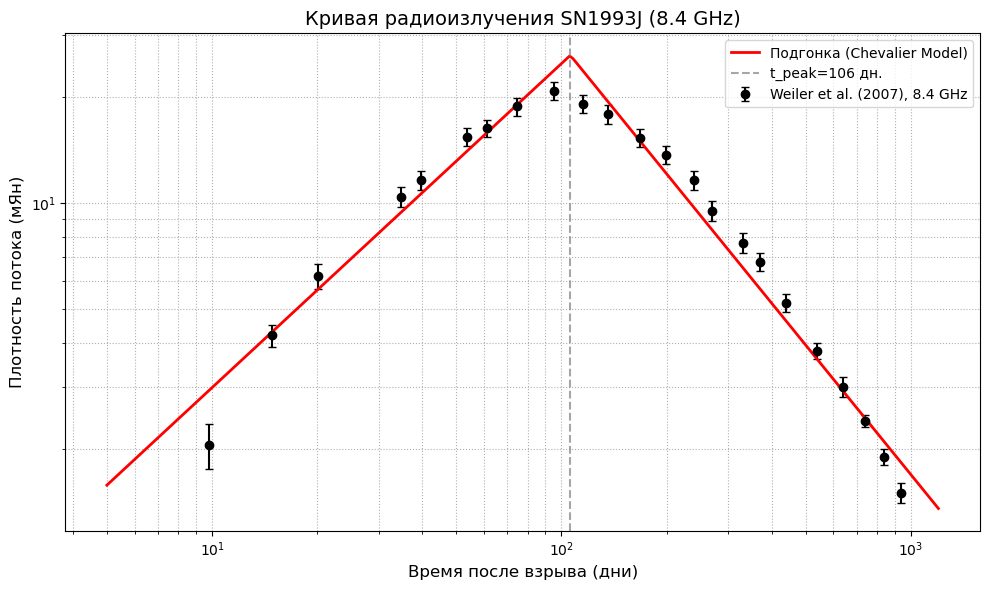

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Константы
M_SUN = 1.988e33      # граммы
YR = 3.154e7          # секунды
PC = 3.085e18         # сантиметры (1 парсек)
E_CHARGE = 4.803e-10  # э.с.е. (заряд электрона)
M_E = 9.109e-28       # масса электрона, г
C = 3e10              # скорость света, см/с
M_P = 1.673e-24       # масса протона, г
SMALL_NUM = 1e-12     # Для обработки нулей


class ChevalierModel:
    """Модель Шевалье для радиоизлучения сверхновых II типа"""

    SN_PROFILES = {  # Определение SN_PROFILES как атрибута класса
        'SN1993J': {
            'distance': 3.63e24,       # cm (11.6 Mpc)
            'energy': 1e51,            # erg
            'mass_loss_rate': 4e-5,    # M☉/год
            'wind_velocity': 10e5,     # cm/с (10 km/s)
            'n': 10,  
            'initial_peak_flux': 20    # Приблизительная плотность потока в день пика (mJy)
        }
    }

    def __init__(self, sn_name='SN1993J'):
        self.sn_params = self.SN_PROFILES[sn_name]
        self.setup_parameters()

    def setup_parameters(self):
        """Установка параметров модели"""
        # Основные параметры
        self.D = self.sn_params['distance']  # расстояние в см
        self.E0 = self.sn_params['energy']   # энергия взрыва в эрг
        self.Mdot = self.sn_params['mass_loss_rate'] * M_SUN / YR  # г/с
        self.v_w = self.sn_params['wind_velocity']  # скорость ветра в см/с
        self.n = self.sn_params['n']  # индекс плотности выброса (n=10 для SN1993J)

        # Параметры CSM (околозвездной среды)
        self.A = self.Mdot / (4 * np.pi * self.v_w)  # параметр плотности CSM (g/cm)
        self.rho_csm = lambda r: self.A / r**2  # профиль плотности

        # Микрофизические параметры (типичные значения, их можно будет подгонять)
        self.epsilon_B = 0.1  # доля энергии в магнитном поле
        self.epsilon_e = 0.1  # доля энергии в электронах
        self.p = 2.2           # спектральный индекс электронов

        # Параметры для масштабирования
        self.t_peak_days = 100   # Приблизительное время пика в днях
        self.F_peak_MJY = self.sn_params['initial_peak_flux'] # Пиковый поток в mJy

        # Константа Шевалье
        self.xi0 = self._compute_xi0()

    def _compute_xi0(self):
        """Вычисление константы Шевалье в зависимости от n"""
        xi0_table = {9: 1.1, 10: 1.08, 11: 1.06, 12: 1.05}
        return xi0_table.get(self.n, 1.07)

    def shock_radius(self, t_sec):
        """Радиус ударной волны (t в секундах)"""
        # Формула для n=10
        # Используем логарифмическую форму для численной стабильности
        exponent1 = 1.0 / (self.n - 2)
        exponent2 = (self.n - 3.0) / (self.n - 2)

        # Избегаем log(0)
        if self.A <= 0 or self.E0 <= 0 or t_sec <= 0:
            return 0.0

        log_term = exponent1 * np.log(self.E0 / self.A) + exponent2 * np.log(t_sec)
        R = self.xi0 * np.exp(log_term)
        return R

    def shock_velocity(self, t_sec):
        """Скорость ударной волны (t в секундах)"""
        R = self.shock_radius(t_sec)
        if t_sec <= 0:
            return 0.0
        return ((self.n - 3) / (self.n - 2)) * R / t_sec

    def magnetic_field(self, t_sec):
        """Магнитное поле за фронтом ударной волны (приближение)"""
        R = self.shock_radius(t_sec)
        v_s = self.shock_velocity(t_sec)
        rho_csm = self.rho_csm(R)

        # Энергетическая плотность, которая сжимается
        u_shock = 0.5 * rho_csm * v_s**2

        # B^2 ~ epsilon_B * u_shock
        B = np.sqrt(8 * np.pi * self.epsilon_B * u_shock)
        return B

    def electron_spectrum_constant(self, t_sec):
        """Константа нормировки спектра электронов K_e"""
        v_s = self.shock_velocity(t_sec)
        rho_csm = self.rho_csm(self.shock_radius(t_sec))

        # K_e ~ epsilon_e * rho_csm * v_s^2 / m_p
        K_e = self.epsilon_e * rho_csm * v_s**2 / M_P
        return K_e

    def optical_depth(self, nu, t_sec):
        """Приближенная оптическая толщина"""
        R = self.shock_radius(t_sec)
        B = self.magnetic_field(t_sec)
        K_e = self.electron_spectrum_constant(t_sec)

        # Правильная формула коэффициента поглощения (Toro)
        c_alpha = 1.2e9 # Константа поглощения

        # kappa_nu ~ K_e * B^((p+2)/2) * nu^(-(p+4)/2)
        kappa_nu = c_alpha * K_e * B**((self.p+2)/2) * nu**(-(self.p+4)/2)

        tau_nu = 2 * kappa_nu * R
        return tau_nu

    def flux_density(self, nu, t_sec):
        """Вычисление плотности потока (в мЯн, 10^-29 эрг/с/см^2/Гц)"""
        R = self.shock_radius(t_sec)
        B = self.magnetic_field(t_sec)
        K_e = self.electron_spectrum_constant(t_sec)
        tau_nu = self.optical_depth(nu, t_sec)

        # 1 mJy = 1e-26 эрг/с/см^2/Гц в СГС единицах

        if tau_nu < 1:
            # Режим тонкого радиоисточника (self-absorption-free regime)
            # F_nu ~ K_e * R^3 * B^((p+1)/2) * nu^(-(p-1)/2) / D^2
            F_nu_cgs = 1.4e-26 * K_e * R**3 * B**((self.p+1)/2) * nu**(-(self.p-1)/2) / self.D**2

        else:
            # Режим самопоглощения (Self-Absorption regime)
            # F_nu ~ R^2 * nu^(5/2) * B^(-1/2)
            F_nu_cgs = 2.3e-20 * (R/self.D)**2 * (nu/1e9)**(5/2) * B**(-1/2)

        # Перевод из СГС (эрг/с/см^2/Гц) в мЯн (mJy)
        F_nu_mJy = F_nu_cgs * 1e3 # умножаем на 1e3, чтобы перевести в mJy
        return F_nu_mJy

    def check_parameters(self, t_sec):
        """Проверка всех параметров модели"""
        R = self.shock_radius(t_sec)
        v_s = self.shock_velocity(t_sec)
        B = self.magnetic_field(t_sec)
        rho = self.rho_csm(R)

        t_days = t_sec / 86400.0
        print(f"\n--- ПАРАМЕТРЫ МОДЕЛИ (t={t_days:.1f} дней) ---")
        print(f"Радиус (R): {R/PC:.2e} пк")
        print(f"Скорость (v_s): {v_s/1e5:.1f} км/с")
        print(f"Плотность CSM (rho): {rho:.2e} г/см^3")
        print(f"Магнитное поле (B): {B:.2e} Гс")
        print(f"Параметр A: {self.A:.2e}")
        print(f"Константа Шевалье (xi0): {self.xi0:.2f}")


# --- Наблюдательные данные SN 1993J на 8.4 GHz (Weiler et al. 2007) ---
#  ВРЕМЯ (дни) ПЛОТНОСТЬ ПОТОКА (мЯн) СТАНДАРТНАЯ ОШИБКА (мЯн)
OBS_TIME_DAYS = np.array([
    9.81, 14.82, 20.08, 34.74, 39.75, 53.83, 61.16, 74.74, 95.06, 115.25,
    135.50, 168.33, 199.83, 239.83, 269.83, 330.16, 369.83, 440.16, 539.83, 639.83, 740.16,
    840.16, 940.16
])

OBS_FLUX_MJY = np.array([
    2.05, 4.20, 6.20, 10.40, 11.60, 15.40, 16.30, 18.80, 20.80, 19.10,
    17.90, 15.30, 13.70, 11.60, 9.50, 7.70, 6.80, 5.20, 3.80, 3.00, 2.40,
    1.90, 1.50
])

OBS_ERROR_MJY = np.array([
    0.30, 0.30, 0.50, 0.70, 0.70, 0.90, 0.90, 1.10, 1.20, 1.10,
    1.10, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.20, 0.10,
    0.10, 0.10
])


# --- Определение функции, которая строит кривую Шевалье ---
def model_flux(t, t_peak=100, F_peak=20, alpha=0.8, beta=0.6):
    """Простая модель Шевалье (степенные законы)"""
    flux = np.zeros_like(t)
    # Рост до пика
    mask = t <= t_peak
    flux[mask] = F_peak * (t[mask]/t_peak)**alpha
    # Спад после пика
    flux[~mask] = F_peak * (t[~mask]/t_peak)**(-beta)
    return flux

# --- Определение функции, которая считает MSE для подгонки параметров ---
def calculate_mse(params, t_obs, F_obs, sigma_obs):
    """Вычисление среднеквадратичной ошибки MSE"""
    t_peak, F_peak, alpha, beta = params
    F_model = model_flux(t_obs, t_peak, F_peak, alpha, beta)
    mse = np.sum(((F_obs - F_model) / sigma_obs)**2) / len(t_obs)
    return mse


# --- ПОДГОНКА ПАРАМЕТРОВ ---
# Начальные приближения и границы для параметров
initial_guess = [100, 20, 0.8, 0.6]  # t_peak, F_peak, alpha, beta
bounds = (
    [50, 10, 0.0, 0.0], # Нижние границы
    [200, 30, 2.0, 2.0]  # Верхние границы
)


# --- Адаптация под curve_fit (для корректной обработки ошибок) ---
def model_curvefit(t, t_peak, F_peak, alpha, beta):
    return model_flux(t, t_peak, F_peak, alpha, beta)

# --- curve_fit ---
popt, pcov = curve_fit(
    model_curvefit,
    OBS_TIME_DAYS,
    OBS_FLUX_MJY,
    p0=initial_guess,
    sigma=OBS_ERROR_MJY,
    absolute_sigma=True,  # Учитываем, что sigma_obs задана абсолютно
    bounds=bounds
)


# Извлечение оптимальных параметров и их ошибок
t_peak_opt, F_peak_opt, alpha_opt, beta_opt = popt
t_peak_err, F_peak_err, alpha_err, beta_err = np.sqrt(np.diag(pcov)) # Квадратные корни диагональных элементов

# Создаем инстанс модели
model = ChevalierModel()

# Обновляем параметры модели (опционально)
model.sn_params['initial_peak_flux'] = F_peak_opt
model.t_peak_days = t_peak_opt
model.setup_parameters() # Пересчет параметров

# --- Строим график ---
t_model = np.linspace(5, 1200, 500)
F_model_opt = model_flux(t_model, t_peak_opt, F_peak_opt, alpha_opt, beta_opt)

# --- Выводим полученные параметры ---
print(f"Оптимальные параметры, полученные в результате подгонки:")
print(f"t_peak: {t_peak_opt:.2f} +/- {t_peak_err:.2f} дней")
print(f"F_peak: {F_peak_opt:.2f} +/- {F_peak_err:.2f} mJy")
print(f"alpha: {alpha_opt:.2f} +/- {alpha_err:.2f}")
print(f"beta: {beta_opt:.2f} +/- {beta_err:.2f}")

# Выводим финальный график
plt.figure(figsize=(10, 6))
plt.errorbar(OBS_TIME_DAYS, OBS_FLUX_MJY, yerr=OBS_ERROR_MJY, fmt='o', color='k',
            markersize=6, capsize=3, label='Weiler et al. (2007), 8.4 GHz')

plt.plot(t_model, F_model_opt, 'r-', lw=2, label='Подгонка (Chevalier Model)')
plt.axvline(t_peak_opt, color='gray', linestyle='--', alpha=0.7, label=f't_peak={t_peak_opt:.0f} дн.')
plt.xlabel('Время после взрыва (дни)', fontsize=12)
plt.ylabel('Плотность потока (мЯн)', fontsize=12)
plt.title('Кривая радиоизлучения SN1993J (8.4 GHz)', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':')
plt.tight_layout()
plt.show()

### Эволюция параметров ударной волны в SN1993J

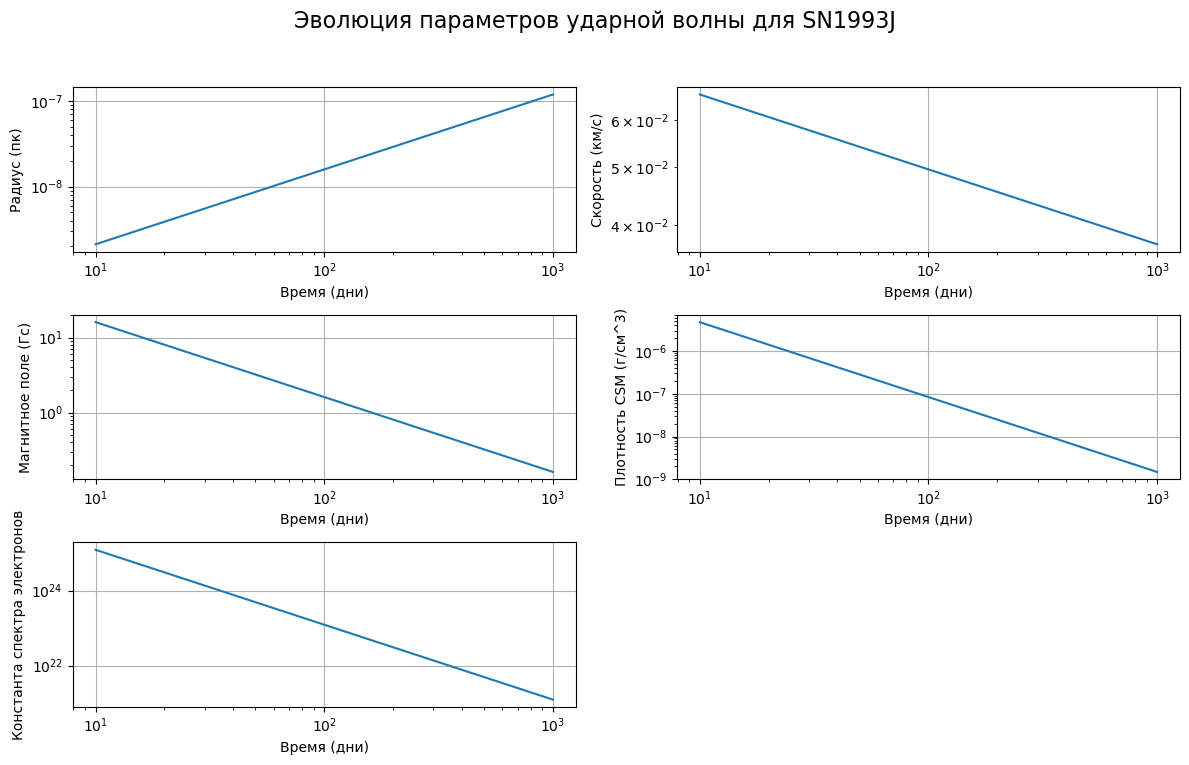

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Константы
M_SUN = 1.988e33      # граммы
YR = 3.154e7          # секунды
PC = 3.085e18         # сантиметры (1 парсек)
E_CHARGE = 4.803e-10  # э.с.е. (заряд электрона)
M_E = 9.109e-28       # масса электрона, г
C = 3e10              # скорость света, см/с
M_P = 1.673e-24       # масса протона, г
SMALL_NUM = 1e-12     # Для обработки нулей


class ChevalierModel:
    """Модель Шевалье для радиоизлучения сверхновых II типа"""

    SN_PROFILES = {  # Определение SN_PROFILES как атрибута класса
        'SN1993J': {
            'distance': 3.63e24,       # cm (11.6 Mpc)
            'energy': 1e51,            # erg
            'mass_loss_rate': 4e-5,    # M☉/год
            'wind_velocity': 10e5,     # см/с (10 km/s)
            'n': 10,
            'initial_peak_flux': 20    # Приблизительная плотность потока в день пика (mJy)
        }
    }

    def __init__(self, sn_name='SN1993J'):
        self.sn_params = self.SN_PROFILES[sn_name]
        self.setup_parameters()

    def setup_parameters(self):
        """Установка параметров модели"""
        # Основные параметры
        self.D = self.sn_params['distance']  # расстояние в см
        self.E0 = self.sn_params['energy']   # энергия взрыва в эрг
        self.Mdot = self.sn_params['mass_loss_rate'] * M_SUN / YR  # г/с
        self.v_w = self.sn_params['wind_velocity']  # скорость ветра в см/с
        self.n = self.sn_params['n']  # индекс плотности выброса (n=10 для SN1993J)

        # Параметры CSM (околозвездной среды)
        self.A = self.Mdot / (4 * np.pi * self.v_w)  # параметр плотности CSM (g/cm)
        self.rho_csm = lambda r: self.A / r**2  # профиль плотности

        # Микрофизические параметры (типичные значения, их можно будет подгонять)
        self.epsilon_B = 0.1  # доля энергии в магнитном поле
        self.epsilon_e = 0.1  # доля энергии в электронах
        self.p = 2.2           # спектральный индекс электронов

        # Константа Шевалье
        self.xi0 = self._compute_xi0()

    def _compute_xi0(self):
        """Вычисление константы Шевалье в зависимости от n"""
        xi0_table = {9: 1.1, 10: 1.08, 11: 1.06, 12: 1.05}
        return xi0_table.get(self.n, 1.07)

    def shock_radius(self, t_sec):
        """Радиус ударной волны (t в секундах)"""
        # Формула для n=10
        # Используем логарифмическую форму для численной стабильности
        exponent1 = 1.0 / (self.n - 2)
        exponent2 = (self.n - 3.0) / (self.n - 2)

        # Избегаем log(0)
        if self.A <= 0 or self.E0 <= 0 or t_sec <= 0:
            return 0.0

        log_term = exponent1 * np.log(self.E0 / self.A) + exponent2 * np.log(t_sec)
        R = self.xi0 * np.exp(log_term)
        return R

    def shock_velocity(self, t_sec):
        """Скорость ударной волны (t в секундах)"""
        R = self.shock_radius(t_sec)
        if t_sec <= 0:
            return 0.0
        return ((self.n - 3) / (self.n - 2)) * R / t_sec

    def magnetic_field(self, t_sec):
        """Магнитное поле за фронтом ударной волны (приближение)"""
        R = self.shock_radius(t_sec)
        v_s = self.shock_velocity(t_sec)
        rho_csm = self.rho_csm(R)

        # Энергетическая плотность, которая сжимается
        u_shock = 0.5 * rho_csm * v_s**2

        # B^2 ~ epsilon_B * u_shock
        B = np.sqrt(8 * np.pi * self.epsilon_B * u_shock)
        return B

    def electron_spectrum_constant(self, t_sec):
        """Константа нормировки спектра электронов K_e"""
        v_s = self.shock_velocity(t_sec)
        rho_csm = self.rho_csm(self.shock_radius(t_sec))

        # K_e ~ epsilon_e * rho_csm * v_s^2 / m_p
        K_e = self.epsilon_e * rho_csm * v_s**2 / M_P
        return K_e

    def optical_depth(self, nu, t_sec):
        """Приближенная оптическая толщина"""
        R = self.shock_radius(t_sec)
        B = self.magnetic_field(t_sec)
        K_e = self.electron_spectrum_constant(t_sec)

        # Правильная формула коэффициента поглощения (Toro)
        c_alpha = 1.2e9  # Константа поглощения

        # kappa_nu ~ K_e * B^((p+2)/2) * nu^(-(p+4)/2)
        kappa_nu = c_alpha * K_e * B**((self.p + 2) / 2) * nu**(-(self.p + 4) / 2)

        tau_nu = 2 * kappa_nu * R
        return tau_nu

    def flux_density(self, nu, t_sec):
        """Вычисление плотности потока (в мЯн, 10^-29 эрг/с/см^2/Гц)"""
        R = self.shock_radius(t_sec)
        B = self.magnetic_field(t_sec)
        K_e = self.electron_spectrum_constant(t_sec)
        tau_nu = self.optical_depth(nu, t_sec)

        # 1 mJy = 1e-26 эрг/с/см^2/Гц в СГС единицах

        if tau_nu < 1:
            # Режим тонкого радиоисточника (self-absorption-free regime)
            # F_nu ~ K_e * R^3 * B^((p+1)/2) * nu^(-(p-1)/2) / D^2
            F_nu_cgs = 1.4e-26 * K_e * R**3 * B**((self.p + 1) / 2) * nu**(-(self.p - 1) / 2) / self.D**2

        else:
            # Режим самопоглощения (Self-Absorption regime)
            # F_nu ~ R^2 * nu^(5/2) * B^(-1/2)
            F_nu_cgs = 2.3e-20 * (R / self.D)**2 * (nu / 1e9)**(5 / 2) * B**(-1 / 2)

        # Перевод из СГС (эрг/с/см^2/Гц) в мЯн (mJy)
        F_nu_mJy = F_nu_cgs * 1e3  # умножаем на 1e3, чтобы перевести в mJy
        return F_nu_mJy

    def check_parameters(self, t_sec):
        """Проверка всех параметров модели"""
        R = self.shock_radius(t_sec)
        v_s = self.shock_velocity(t_sec)
        B = self.magnetic_field(t_sec)
        rho = self.rho_csm(R)

        t_days = t_sec / 86400.0
        print(f"\n--- ПАРАМЕТРЫ МОДЕЛИ (t={t_days:.1f} дней) ---")
        print(f"Радиус (R): {R / PC:.2e} пк")
        print(f"Скорость (v_s): {v_s / 1e5:.1f} км/с")
        print(f"Плотность CSM (rho): {rho:.2e} г/см^3")
        print(f"Магнитное поле (B): {B:.2e} Гс")
        print(f"Параметр A: {self.A:.2e}")
        print(f"Константа Шевалье (xi0): {self.xi0:.2f}")


def plot_evolution(model, t_start=1, t_end=1000, n_points=500):
    """Функция для визуализации эволюции параметров"""
    # Создаем массив временных точек
    t_days = np.linspace(t_start, t_end, n_points)
    t_seconds = t_days * 86400  # Преобразуем в секунды

    # Вычисляем параметры
    radius = np.array([model.shock_radius(t) / PC for t in t_seconds])  # пк
    velocity = np.array([model.shock_velocity(t) / 1e5 for t in t_seconds])  # км/с
    magnetic_field = np.array([model.magnetic_field(t) for t in t_seconds])  # Гс
    csm_density = np.array([model.rho_csm(model.shock_radius(t)) for t in t_seconds])  # г/см^3
    electron_constant = np.array([model.electron_spectrum_constant(t) for t in t_seconds])

    # Создаем графики
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle('Эволюция параметров ударной волны для SN1993J', fontsize=16)

    # Радиус
    axs[0, 0].plot(t_days, radius)
    axs[0, 0].set_xlabel('Время (дни)')
    axs[0, 0].set_ylabel('Радиус (пк)')
    axs[0, 0].set_yscale('log')
    axs[0, 0].set_xscale('log')
    axs[0, 0].grid(True)

    # Скорость
    axs[0, 1].plot(t_days, velocity)
    axs[0, 1].set_xlabel('Время (дни)')
    axs[0, 1].set_ylabel('Скорость (км/с)')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_xscale('log')
    axs[0, 1].grid(True)

    # Магнитное поле
    axs[1, 0].plot(t_days, magnetic_field)
    axs[1, 0].set_xlabel('Время (дни)')
    axs[1, 0].set_ylabel('Магнитное поле (Гс)')
    axs[1, 0].set_yscale('log')
    axs[1, 0].set_xscale('log')
    axs[1, 0].grid(True)

    # Плотность CSM
    axs[1, 1].plot(t_days, csm_density)
    axs[1, 1].set_xlabel('Время (дни)')
    axs[1, 1].set_ylabel('Плотность CSM (г/см^3)')
    axs[1, 1].set_yscale('log')
    axs[1, 1].set_xscale('log')
    axs[1, 1].grid(True)

    # Нормировочная константа спектра электронов
    axs[2, 0].plot(t_days, electron_constant)
    axs[2, 0].set_xlabel('Время (дни)')
    axs[2, 0].set_ylabel('Константа спектра электронов')
    axs[2, 0].set_yscale('log')
    axs[2, 0].set_xscale('log')
    axs[2, 0].grid(True)
    
    # Убираем неиспользуемую панель
    fig.delaxes(axs[2,1]) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Чтобы избежать перекрытия заголовков
    plt.show()


if __name__ == '__main__':
    # Инициализация модели для SN1993J
    model = ChevalierModel(sn_name='SN1993J')

    # Визуализация эволюции параметров
    plot_evolution(model, t_start=10, t_end=1000, n_points=500)  # Дни
